In [1]:
import findspark
findspark.init()

import wptools
import pyspark
import pyspark.sql
from pyspark.sql import *
import os.path
from pyspark.sql.functions import desc

from pyspark.sql import dataframe
from pyspark.sql import functions as F

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import hashlib

%matplotlib inline

import os
import sys
my_fun = './utils/'
if my_fun not in sys.path:
    sys.path.append(my_fun)
    
from get_ref_info import *
my_fun = './utils/cleaning/'
if my_fun not in sys.path:
    sys.path.append(my_fun)
    
from cleaning import *
from operator import add

try:
    from urllib.parse import urlparse
except ImportError:
     from urlparse import urlparse

import seaborn as sns
import numpy as np
from pyspark.sql.functions import regexp_replace, col

from sklearn.preprocessing import MinMaxScaler

import time
from datetime import timedelta, date
from mwviews.api import PageviewsClient
from collections import OrderedDict
DATA_DIR = './data/data_processed/' 

sc.addPyFile("./utils/get_ref_info.py")
sc.addPyFile("./utils/cleaning/cleaning.py")

# Index


## 1. Data Acquisition
### 1.1 Cluster
### 1.2 WpTools


## 2. Preprocessing: Joins and feature standardisation


## 3. Results: data story


----

# 1. DATA ACQUISITION

## 1.1 On the cluster

We initially used the cluster to retrieve all conflicts within all wikipedia articles. We filter pages per category: 
* civilian attack
* civil conflict
* military conflict

The results of the filtering is sotred in columnar data into the folder `./data/data_processed/selectedAllConflict.parque`

We load this dataset.

### Loading data 

**File schema** is shown.

In [3]:
WIKIPEDIA_CONFLICTS_PARQUET = DATA_DIR + 'selectedAllConflict.parquet'

# loading the saved parquet files
wikipedia_ = spark.read.parquet(WIKIPEDIA_CONFLICTS_PARQUET)
# show file schema
wikipedia_.printSchema()

root
 |-- id: long (nullable = true)
 |-- ns: long (nullable = true)
 |-- restrictions: string (nullable = true)
 |-- revision: struct (nullable = true)
 |    |-- comment: struct (nullable = true)
 |    |    |-- _VALUE: string (nullable = true)
 |    |    |-- _deleted: string (nullable = true)
 |    |-- contributor: struct (nullable = true)
 |    |    |-- _VALUE: string (nullable = true)
 |    |    |-- _deleted: string (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- ip: string (nullable = true)
 |    |    |-- username: string (nullable = true)
 |    |-- format: string (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- minor: string (nullable = true)
 |    |-- model: string (nullable = true)
 |    |-- parentid: long (nullable = true)
 |    |-- sha1: string (nullable = true)
 |    |-- text: struct (nullable = true)
 |    |    |-- _VALUE: string (nullable = true)
 |    |    |-- _xml:space: string (nullable = true)
 |    |-- timestamp: string (nulla

In [4]:
# how many articles are there?
print("Number of articles: {}".format(wikipedia_.count()))

Number of articles: 18782


---

# Article outliers removal

To remove the outliers, we excluded articles with weird categories that do not seem to match conflicts, e.g. museum, legislation, referendum or shopping mal...
In order to do that, we create a set of all categories that are present in our dataset (i.e. military conflicts, civilian conflicts and civilian attack) and we removed all the articles containing the weird categories. This step resulted in **109** article removed.

In [5]:
wikipedia = spark.read.parquet(WIKIPEDIA_CONFLICTS_PARQUET)

In [6]:
regex = r"([A-z].+?(?=,)|[A-z].*?$)"
cat_regex = re.compile(regex,re.IGNORECASE);

In [7]:
categories = [];
def extr_categories(text):
    global categories
    categories = categories + cat_regex.findall(text);

In [8]:
categories = [];
for i in wikipedia.select(F.lower(col('categories')).alias('categories')).collect(): #lcase
    extr_categories(i[0])

In [9]:
categories_unique = list(set(categories))
categories_map = map(str.strip, [str(i) for i in categories_unique])
print(list(categories_map))

['mountain range', 'protected area', 'milit', 'islands', 'historical event', 'newspaper', 'east asian', 'building', 'event', 'monarch', 'united states district court case', 'korean name', 'historic building', 'aircraft incident', 'television', 'nrhp', 'australian place', 'book', 'military conflict', 'civilian attack', 'airport', 'ship begin', 'protected area', 'military person', 'monument', 'news event', 'murderer', 'pahistoric', 'airliner accident', 'legislature', 'operational plan', 'court case', 'subbox = yes', 'service record', 'person', 'aircraft occurrence', 'military conflict  <', 'legislation', 'former country', 'military person', 'ship image', 'treaty', 'military structure', 'mass murderer', 'law enforcement agency', 'nrhp', 'holiday', 'shopping mall', 'film', 'ship career', 'former subdivision', 'uk feature', 'greek dimos', 'football match', 'military operation', 'historic site', 'person', 'national military', 'east asian name', 'election', 'ship characteristics', 'school', '

In [16]:
mainCategories = ['civil conflict','military conflict','civilian attack']

filteredCategoryMap=[]
for i in categories_map:
    if not any(s in i for s in mainCategories):
        if i == 'milit': #Battle of Tolbiac give a problem because of a umlaut
            continue
        filteredCategoryMap+=[i];

filteredCategoryMap = list(set(filteredCategoryMap))
#create a dynamic regex
forReg = '|'.join(filteredCategoryMap);

In [11]:
wikiExtraCat = wikipedia.filter(F.lower(wikipedia.categories).rlike(forReg))
wikiExtraCat.count()

18782

In [12]:
outliers_categories = ['police officer','person','tv channel','historic building',
                       'service record','ship career','news event','legislature'
                       'national military','islands','shopping mall',
                       'museum','legislation','referendum',
                       'nobility','serial killer','officeholder','decat = yes',
                       'television','newspaper','former subdivision','film',
                       'book','bilateral relations','monarch','building','organization']

wikipedia.select("id","title","categories", "revision").filter(F.lower(wikipedia.categories).rlike('|'.join(outliers_categories))).count()

109

This is the number of articles that will be removed.

In [13]:
wikipedia = wikipedia.select("id","title","categories","revision").filter(~F.lower(wikipedia.categories).rlike('|'.join(outliers_categories)))
wikipedia.count()

18673

In [14]:
wikipedia.printSchema()

root
 |-- id: long (nullable = true)
 |-- title: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- revision: struct (nullable = true)
 |    |-- comment: struct (nullable = true)
 |    |    |-- _VALUE: string (nullable = true)
 |    |    |-- _deleted: string (nullable = true)
 |    |-- contributor: struct (nullable = true)
 |    |    |-- _VALUE: string (nullable = true)
 |    |    |-- _deleted: string (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- ip: string (nullable = true)
 |    |    |-- username: string (nullable = true)
 |    |-- format: string (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- minor: string (nullable = true)
 |    |-- model: string (nullable = true)
 |    |-- parentid: long (nullable = true)
 |    |-- sha1: string (nullable = true)
 |    |-- text: struct (nullable = true)
 |    |    |-- _VALUE: string (nullable = true)
 |    |    |-- _xml:space: string (nullable = true)
 |    |-- timestamp: string (nu

In [15]:
# save to binary files 
wikipedia.write.mode('overwrite').parquet("data/data_processed/wikipedia_no_outliers.parquet");

---
# 1.2 WpTools: Quantifying *importance* of each page in each category

We want to see how *important* each page is in each category. As we are solely focusing on *'war'*-related subjects in this pilot phase, we define *page importance* by the number of deaths. 

## Infobox or Wikidata per category 

Functions `get_wiki_civilian_attack`, `get_wiki_military_conflict`
to get relevant information and views for each category: `civilian attack`, `military conflict`. 
Data is obtained either using the page's wikidata is the data exists or acquired through infobox parsing.
Relevant information is chosen based on the fields found on [List of infoboxes and fields](https://en.wikipedia.org/wiki/Wikipedia:List_of_infoboxes#Event) 

Extract info for each category in **Infobox**:
* `civilian attack`
    * location
    * date 
    * fatalities
* `military conflict`
    * place
    * date 
    * casualities1
* `civil conflict`
    * place
    * date 
    * casualities1
    
Extract info for each category in **Wikidata**:
* `civilian attack`
    * location
    * date 
    * fatalities
* `military conflict`
    * 'number of deaths (P1120)']['amount']
    * 'end time (P582)'
    * 'location (P276)'
* `civil conflict`
    * 'number of deaths (P1120)']['amount']
    * 'end time (P582)'
    * 'location (P276)'
    
We use an external library [wptools wiki](https://github.com/siznax/wptools/wiki) to help us parse the data. 

### Categories
We focus on categories : `civilian attack`, `military conflict`, `civil conflict` from our pre-filtered wikipedia dump data which had 3 categories: `civilian attack`, `military conflict`, `civil conflict` (key words we used via regex expression to extract articles containing infoboxes with such headers by parsing the revision.text.__VALUE). 

We also found a list of all ongoing civil wars listed on [wikipedia](https://en.wikipedia.org/wiki/List_of_civil_wars#Ongoing_civil_wars) have a `Template:Infobox military`. This may be of interest in a later step.

[List of ongoing civil wars](https://en.wikipedia.org/wiki/List_of_civil_wars#Ongoing_civil_wars):
 * Myanmar, Internal conflict in Myanmar, since 1948
 * Indonesia, Papua conflict, since 1962
 * Colombia, Colombian conflict, since 1964
 * Afghanistan, War in Afghanistan, since 1978
 * Turkey, Kurdish–Turkish conflict since 1978
 * Somalia, Somali Civil War, since 1988
 * Sudan, three conflicts
* War in Darfur, since 26 February 2003
* Sudanese nomadic conflicts, since 26 May 2009 through at least 2017
* Sudanese conflict in South Kordofan and Blue Nile since 5 June 2011
 * Pakistan, War in North-West Pakistan, since 16 March 2004
 * Paraguay, Paraguayan People's Army insurgency, since 2005
 * Syria, Syrian Civil War, since 15 March 2011, also see List of armed groups in the Syrian Civil War
 * Central African Republic, Central African Republic conflict, since 10 December 2012
 * South Sudan, South Sudanese Civil War, since 15 December 2013
 * Libya, Second Libyan Civil War, since 16 May 2014
 * Yemen, Second Yemeni Civil War, since 19 March 2015

In [4]:
def get_wiki_military_conflict(entity):
    page = wptools.page(pageid=entity.id)
    # extract relevant information and put in dictionary
    info = {'death': None, 'end_date': None, 'location': None}
    try:
        page.get_parse()
    except:
        return Row(id=entity.id, death=info['death'],
               end_date=info['end_date'], location=info['location'])
    
    try: 
        page.get_wikidata()
        info['death'] = page.data['wikidata']['number of deaths (P1120)']['amount']
    
    except:
        try:
            info['death'] = page.data['infobox']['casualties1']
        except:
            info['death'] = None
            
    try:
        info['end_date'] = page.data['wikidata']['end time (P582)']
    except:
        try:
            info['end_date'] = page.data['infobox']['date']
        except:
            info['end_date'] = None
    
    try:
        info['location'] = page.data['wikidata']['location (P276)']
    except:
        try:
            info['location'] = page.data['infobox']['place']
        except:
            info['location'] = None
    
    
    return Row(id=entity.id, death=info['death'],
               end_date=info['end_date'], location=info['location'])

def get_wiki_civilian_attack(entity):
    page = wptools.page(pageid=entity.id)
    # extract relevant information and put in dictionary
    info = {'death': None, 'end_date': None, 'location': None}
    try:
        page.get_parse()
    except:
        return Row(id=entity.id, death=info['death'],
               end_date=info['end_date'], location=info['location'])
    
    try: 
        page.get_wikidata()
        info['death'] = page.data['wikidata']['number of deaths (P1120)']['amount']
    
    except:
        try:
            info['death'] = page.data['infobox']['fatalities']
        except:
            info['death'] = None
            
    try:
        info['end_date'] = page.data['wikidata']['end time (P582)']
    except:
        try:
            info['end_date'] = page.data['infobox']['date']
        except:
            info['end_date'] = None
    
    try:
        info['location'] = page.data['wikidata']['location (P276)']
    except:
        try:
            info['location'] = page.data['infobox']['location']
        except:
            info['location'] = None
    
    
    return Row(id=entity.id, death=info['death'],
               end_date=info['end_date'], location=info['location'])

In [3]:
from pyspark.sql.types import *

### Wikidata & Infobox `military conflict `

In [117]:
infobox_military_conflict = 'military conflict'
# find all pages that have category military conflict
wiki_military_conflict = wikipedia.where("categories like '%{}%'".format(infobox_military_conflict)) 

In [119]:
df = wiki_military_conflict.select("id");
df.count()

14158

In [7]:
%%capture
wiki_military_conflict_rows = [get_wiki_military_conflict(i) for i in df.collect()];

In [9]:
schema = StructType([StructField('death', StringType()),StructField('end_date', StringType()),
                     StructField('id', IntegerType()),StructField('location', StringType())])

In [10]:
wiki_military_attack_df = spark.createDataFrame(wiki_military_conflict_rows, schema)

wiki_military_attack_df.printSchema()
wiki_military_attack_df.show()

root
 |-- death: string (nullable = true)
 |-- end_date: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- location: string (nullable = true)

+--------------------+--------------------+------+--------------------+
|               death|            end_date|    id|            location|
+--------------------+--------------------+------+--------------------+
|Some injuries, no...|    August 1–2, 1946|655845|   Athens (Q3292481)|
|{{ubl|1 light cru...|{{start date|1940...|656035|    Calabria (Q1458)|
|1,432 killed in c...|+1912-10-18T00:00...|656087|Vilayet of Tripol...|
|approx. 1,000 killed|+1919-08-08T00:00...|656173|[[North-West Fron...|
|Total fatalities ...|+1880-00-00T00:00...|656175|[Emirate of Afgha...|
|                null|July 1778 – Febru...|656473|Illinois Country ...|
|250–300 casualtie...|    2–5 October 1939|659156|      Kock (Q991819)|
|         '''1,900'''|{{Start date|1864...|659506|Fulton County (Q4...|
|                null|1961–1990 (29 years)|661656|

In [11]:
# saving binary file to future uses
wiki_military_attack_df.write.mode('overwrite').parquet("data/data_processed/wiki_military_conflict_df.parquet");

### Wikidata & Infobox `civilian attack`

In [130]:
infobox_civilian_attack = 'civilian attack'
# find all pages that have category civilian attack
wiki_civilian_attack = wikipedia.where("categories like '%{}%'".format(infobox_civilian_attack));

In [132]:
df = wiki_civilian_attack.select("id");
df.count()

2468

In [133]:
%%capture
wiki_civilian_attack_rows = [get_wiki_civilian_attack(i) for i in df.collect()];

In [5]:
schema = StructType([StructField('id', IntegerType()),
                     StructField('death', StringType()),StructField('end_date', StringType()),
                     StructField('location', StringType())])

In [134]:
wiki_civilian_attack_df = spark.createDataFrame(wiki_civilian_attack_rows, schema)

wiki_civilian_attack_df.printSchema()
wiki_civilian_attack_df.show()

root
 |-- id: integer (nullable = true)
 |-- death: string (nullable = true)
 |-- end_date: string (nullable = true)
 |-- location: string (nullable = true)

+-------+--------------------+--------------------+--------------------+
|     id|               death|            end_date|            location|
+-------+--------------------+--------------------+--------------------+
| 676659|   500,000–1,000,000|7 April {{spaced ...|          [[Rwanda]]|
| 683450|[[Patrick Argüell...|6– {{end date|df|...|     Zarqa (Q148062)|
|1611176|        Up to 30,000|          April 1909|Adana Vilayet (Q1...|
|1611202|     200,000–400,000|           1894–1896|Ottoman Empire (Q...|
|1634876|10 (including the...|                null| Red Lake (Q1012803)|
|1655234|                  +7|          1 May 2004|     Yanbu (Q466027)|
|3119912|                  +1|    November 8, 2005|Jacksboro (Q2738438)|
|3137442|Barbara Richardso...|{{start date|1981...|8763 Wonderland A...|
|3177125|:16 (at least) 
*...|: August 

In [135]:
wiki_civilian_attack_df.count()

2468

In [136]:
# saving binary file to future uses
wiki_civilian_attack_df.write.mode('overwrite').parquet("wiki_civilian_attack_df.parquet");

### Wikidata & Infobox `civil conflict`

In [137]:
infobox_civil_conflict = 'civil conflict'
# find all pages that have category civilian attack
wiki_civil_conflict = wikipedia.where("categories like '%{}%'".format(infobox_civil_conflict)) 

In [140]:
df = wiki_civil_conflict.select("id");
df.count()

847

In [141]:
%%capture
wiki_civil_conflict_rows = [get_wiki_military_conflict(i) for i in df.collect()];

In [142]:
wiki_civil_conflict_df = spark.createDataFrame(wiki_civil_conflict_rows, schema)

wiki_civil_conflict_df.printSchema()
wiki_civil_conflict_df.show()

root
 |-- id: integer (nullable = true)
 |-- death: string (nullable = true)
 |-- end_date: string (nullable = true)
 |-- location: string (nullable = true)

+-------+--------------------+--------------------+--------------------+
|     id|               death|            end_date|            location|
+-------+--------------------+--------------------+--------------------+
| 661864|                null|11, 12 and 13 Sep...|[[Melbourne]], [[...|
| 664490|'''Deaths''': 3<b...|  January–March 1912|[[Lawrence, Massa...|
|1613199|                null|May 28 and July 2...|[[East St. Louis,...|
|1619134|                null|February 24, 2005...|  [[Quebec]], Canada|
|3138671|'''Shootout''':<b...|July 23–24, 1968 ...|[[Glenville, Clev...|
|3158301|                null|            May 1971|[[Washington, D.C...|
|1113889|                  +2|  August 19–21, 1991|[[Crown Heights, ...|
| 152287|{{plainlist|
*14 ...|[+1878-07-19T00:0...|[[Lincoln County,...|
|  43573|                null|      Apr

In [143]:
wiki_civil_conflict_df.count()

847

In [144]:
# saving binary file to future uses
wiki_civil_conflict_df.write.mode('overwrite').parquet("wiki_civil_conflict_df.parquet");

---

# 2. Preprocessing
## Popularity Metrics

### Loading the data

In [3]:
# Loading the data
WIKIPEDIA_REFERENCES_PARQUET = DATA_DIR + "intermediate/wikipedia_no_outliers.parquet"

# loading the saved parquet files
wikipedia_ref = spark.read.parquet(WIKIPEDIA_REFERENCES_PARQUET)
wikipedia_ref.show(10)

+------+--------------------+-----------------+--------------------+
|    id|               title|       categories|            revision|
+------+--------------------+-----------------+--------------------+
|655845|Battle of Athens ...|military conflict|[, [,, 5175837,, ...|
|656035|  Battle of Calabria|military conflict|[[link,], [,, 268...|
|656087|   Italo-Turkish War|military conflict|[, [,,, 96.77.37....|
|656173|Third Anglo-Afgha...|military conflict|[[Formatting.,], ...|
|656175|Second Anglo-Afgh...|military conflict|[[/* 1879 */The B...|
|656473|   Illinois campaign|military conflict|[[Moved images.,]...|
|659156|Battle of Kock (1...|military conflict|[, [,, 29980587,,...|
|659506|Battle of Peachtr...|military conflict|[[c/e.,], [,, 193...|
|661656|Nicaraguan Revolu...|military conflict|[, [,, 33124044,,...|
|661864|       S11 (protest)|   civil conflict|[[Rescuing 3 sour...|
+------+--------------------+-----------------+--------------------+
only showing top 10 rows



## POPULARITY METRIC 1

### Get number of references per page

We use our pre-filtered data and we count the number of tag of type ```<ref>```, by parsing all pages to get the number of references. We think that the more *popular* a page is, the more references it will contain.

We want to see:
* how many references a page has
* what does the distribution of the references look like 
* what are the top domains across these articles 
* how many articles have a reference to each domain

The analysis is based on work from *Research:Characterizing Wikipedia Citation Usage*: [MetaPageQueries](https://meta.wikimedia.org/wiki/Research:Characterizing_Wikipedia_Citation_Usage/First_Round_of_Analysis#Dimensions_of_Analysis)

Example of reference format:
```html
<ref>{{cite web| url=http://geonames.nga.mil/ggmagaz/geonames4.asp 
    |title=NGA GeoName Database |publisher=[[National Geospatial Intelligence Agency]] 
    |accessdate=2008-07-05 
    |archiveurl = https://web.archive.org/web/20080608190852/http://geonames.nga.mil/ggmagaz/geonames4.asp 
    <!-- Bot retrieved archive --> |archivedate = 2008-06-08}}</ref>
```

**quantify the number of references per page**
    * using regex expression to find the references in the page
    * counting the number of references

In [4]:
# quantify the number of references per page

# Compile a regular expression pattern into a regular expression object, 
#which can be used for matching using its findall.
just_ref_regex = re.compile(r'<ref[^>]*[^\/]>|<ref[ ]*>')

# find # references <ref> per page 
def get_refs_count(entity, regex_expression=just_ref_regex ):
    # get access to value in text in revision
    text = entity.revision.text._VALUE
    # find references
    refs = just_ref_regex.findall(text)
    return Row(id=entity.id, refs_count=len(refs), categories=entity.categories)

In [5]:
# get the # of references per page
# Creates a DataFrame from an RDD, apply counting function with regex expression
reference_count_page = sqlContext.createDataFrame(wikipedia_ref.rdd.map(get_refs_count))
reference_count_page.sort('refs_count', ascending=False).show(5)
reference_count_page_sql = reference_count_page.registerTempTable('reference_count_page_sql')

+-----------------+--------+----------+
|       categories|      id|refs_count|
+-----------------+--------+----------+
|military conflict|52019122|      1000|
|military conflict|46230181|       818|
|military conflict|42563745|       734|
|military conflict|43243199|       609|
|military conflict|     771|       598|
+-----------------+--------+----------+
only showing top 5 rows



In [6]:
# quantify the # articles with # ref > 0: 
non_zero_ref_query = """
select count(DISTINCT id)
from reference_count_page_sql
where refs_count > 0
"""
non_zero_articles = spark.sql(non_zero_ref_query)

non_zero_articles_pd = non_zero_articles.toPandas().iloc[0,0]
print("Number of articles with #references > 0: " + str(non_zero_articles_pd))

Number of articles with #references > 0: 15879


In [13]:
reference_count_page.head()

Row(categories='military conflict', id=655845, refs_count=43)

**Distribution of number of references** We bin the number of references to get the number of pages having at least x #references. This is observed with a histogram plot.

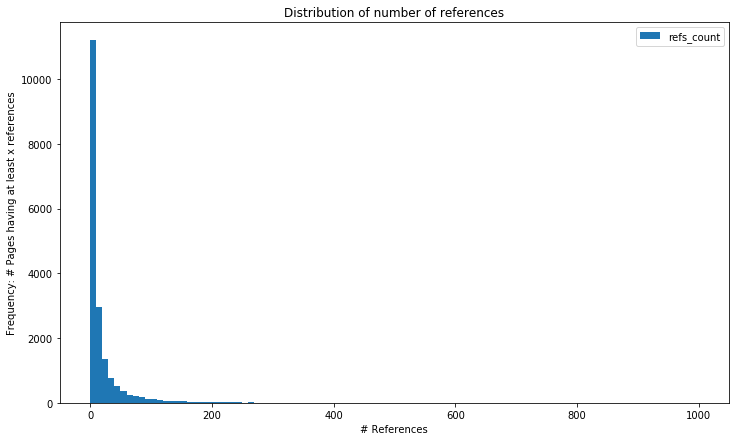

,count,mean,std,min,25%,50%,75%,max
refs_count,18673.0,20.090666,43.422229,0.0,2.0,6.0,19.0,1000.0


In [14]:
just_refs_count = reference_count_page.select('refs_count').toPandas()
just_refs_count.plot(kind="hist", bins=100, 
                     figsize=(12,7), title="Distribution of number of references")
plt.xlabel('# References')
plt.ylabel('Frequency: # Pages having at least x references')
plt.show()
just_refs_count.describe().T

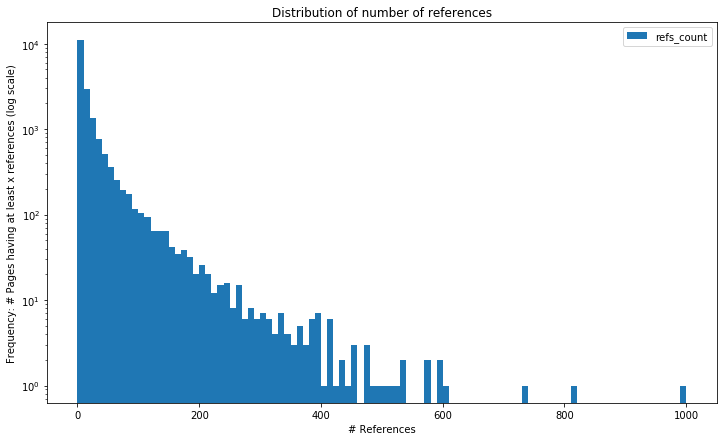

In [23]:
just_refs_count = reference_count_page.select('refs_count').toPandas()
just_refs_count.plot(kind="hist", bins=100, log = True,
                     figsize=(12,7), title="Distribution of number of references")
plt.xlabel('# References')
plt.ylabel('Frequency: # Pages having at least x references (log scale)')
plt.show()

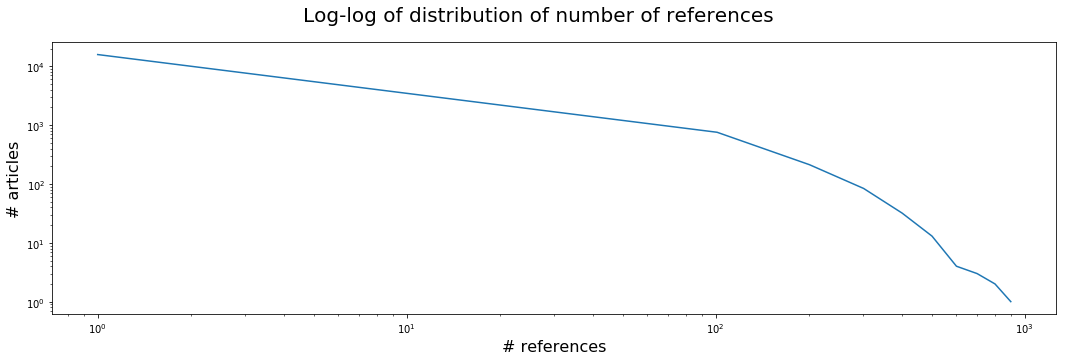

In [24]:
step = 100;
xs = pd.Series(range(1,int(just_refs_count.max()),step));
gratherThanData = xs.apply(lambda x: (just_refs_count.refs_count[just_refs_count.refs_count>=x]).count());

f, (ax2) = plt.subplots(1, 1);
plt.sca(ax2);
plt.plot(xs,gratherThanData);
plt.xlabel('# references',fontsize=16);
plt.ylabel('# articles',fontsize=16);
plt.yscale('log'); plt.xscale('log');
f.set_size_inches(18, 5)
f.suptitle('Log-log of distribution of number of references',fontsize=20)
plt.show();

**Distribution of number of references**: It seems that the distribution may follow a power law. To verify our suspicions, we plot our cumulative distribution in normal axes and in log-log axes. We look at a "cumulative distribution": how many references have at least x pages?

The distribution has a heavy-tailed distribution: it may follow a power law. To recognize if the distirbutions follow a power law, we plot the data in log-log axes. If it follows a power law, reporting mean or variance for a power-law-distributed data is not relevant as these statistics are not robust as they are sensitive to data. Instead, we use robust statistics and report the median and quartiles using boxplots. We compare boxplots with and without outliers.

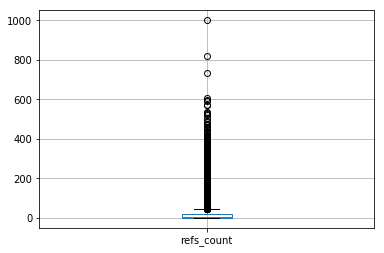

In [25]:
# with all data
just_refs_count.boxplot();

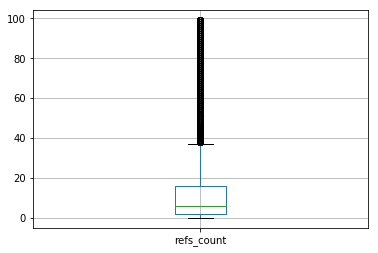

In [26]:
# without extreme values (discard outliers)
just_refs_count[just_refs_count['refs_count']< 100].boxplot();

### Get the domains of references

In [35]:
references_rrd = wikipedia_ref.rdd.flatMap(get_ref_info)
references = sqlContext.createDataFrame(references_rrd)
references.show(5)

+------+---------+--------------------+--------------------+
|    id| template|               title|                 url|
+------+---------+--------------------+--------------------+
|655845|cite book|     South vs. South|                    |
|655845|cite book|       McMinn County|https://archive.o...|
|655845|cite book|     South vs. South|                    |
|655845|cite book|       McMinn County|https://archive.o...|
|655845| cite web|The Battle of Athens|http://www.americ...|
+------+---------+--------------------+--------------------+
only showing top 5 rows



**URL parsing** 
Parse a URL into six components, returning a 6-tuple. This corresponds to the general structure of a URL: scheme://netloc/path;parameters?query#fragment. Each tuple item is a string, possibly empty.

In [38]:
def get_domain(row):
    # parse url and return for each row (url, 1) where 1 is the occurence of ref = 1 for that page
    try:
        parsed_uri = urlparse(row['url'])
        return ('{uri.netloc}'.format(uri=parsed_uri), 1)
    except:
        return None

mapped_domains = references.where("length(url)>0").rdd.map(get_domain).filter(lambda row: row is not None)
# for each domain count how many references there are in total to find top domains
domains_count = mapped_domains.reduceByKey(lambda a,b: a+b).filter(lambda r: len(r[0])>0).sortBy(lambda r: -r[1])
domains_count.take(30)

[('books.google.com', 10113),
 ('www.nytimes.com', 4170),
 ('www.reuters.com', 3715),
 ('www.almasdarnews.com', 3397),
 ('www.theguardian.com', 3313),
 ('www.bbc.co.uk', 2829),
 ('news.bbc.co.uk', 2318),
 ('www.aljazeera.com', 1988),
 ('www.washingtonpost.com', 1970),
 ('www.bbc.com', 1962),
 ('www.cnn.com', 1541),
 ('www.syriahr.com', 1518),
 ('www.telegraph.co.uk', 1505),
 ('edition.cnn.com', 1170),
 ('www.independent.co.uk', 976),
 ('abcnews.go.com', 840),
 ('twitter.com', 811),
 ('www.haaretz.com', 707),
 ('www.foxnews.com', 689),
 ('www.dailystar.com.lb', 682),
 ('www.dawn.com', 678),
 ('www.jpost.com', 677),
 ('www.wsj.com', 626),
 ('www.youtube.com', 619),
 ('news.yahoo.com', 614),
 ('www.cbsnews.com', 607),
 ('archive.org', 605),
 ('www.huffingtonpost.com', 580),
 ('www.latimes.com', 577),
 ('www.dailymail.co.uk', 565)]

In [39]:
# count the number of links
number_links = domains_count.map(lambda r: r[1]).reduce(add)
print("Total number of links: {}".format(number_links))

Total number of links: 163487


In [40]:
def percentage(rdd):
    return Row(domain=rdd[0], count=rdd[1], perc=rdd[1]*100/number_links)

domains_distribution = sqlContext.createDataFrame(domains_count.map(percentage)).sort("count", ascending=False)
domains_distribution.show()

+-----+--------------------+-------------------+
|count|              domain|               perc|
+-----+--------------------+-------------------+
|10113|    books.google.com|  6.185812939255109|
| 4170|     www.nytimes.com| 2.5506615204878673|
| 3715|     www.reuters.com| 2.2723519301228845|
| 3397|www.almasdarnews.com|  2.077841051582083|
| 3313| www.theguardian.com| 2.0264608195147016|
| 2829|       www.bbc.co.uk| 1.7304128156978842|
| 2318|      news.bbc.co.uk| 1.4178497372879801|
| 1988|   www.aljazeera.com| 1.2159988255946956|
| 1970|www.washingtonpos...|  1.204988775865971|
| 1962|         www.bbc.com| 1.2000954204309824|
| 1541|         www.cnn.com| 0.9425825906647012|
| 1518|     www.syriahr.com| 0.9285141937891086|
| 1505| www.telegraph.co.uk|  0.920562491207252|
| 1170|     edition.cnn.com| 0.7156532323670995|
|  976|www.independent.c...| 0.5969893630686232|
|  840|      abcnews.go.com|  0.513802320673815|
|  811|         twitter.com|0.49606390722198096|
|  707|     www.haar

In [41]:
domains_distribution_pd = domains_distribution.toPandas().set_index('domain')

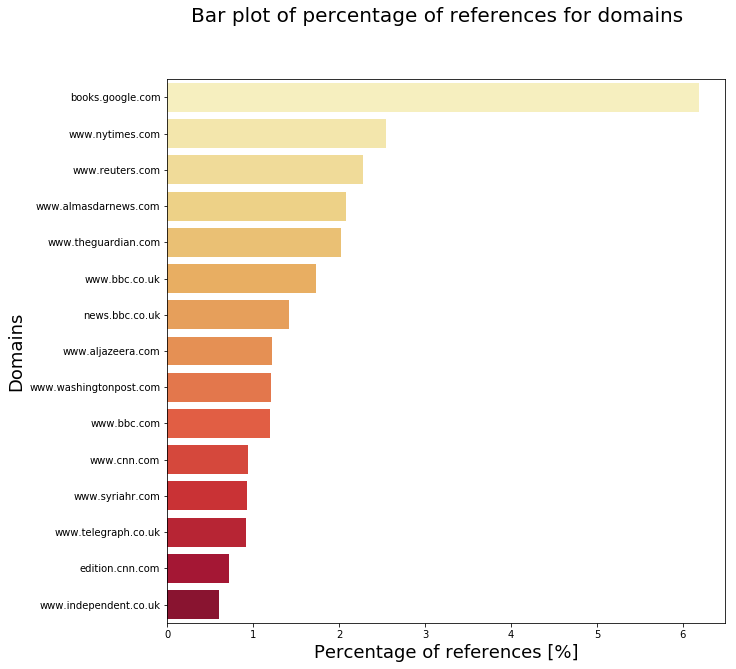

In [42]:
domains_distribution_pd20 = domains_distribution_pd.head(15)

# plot using bar plot
f, ax1 = plt.subplots()
plt.sca(ax1)
sns.barplot(domains_distribution_pd20['perc'], domains_distribution_pd20.index, palette="YlOrRd", ax=ax1, orient='h')
plt.xlabel('Percentage of references [%]',fontsize=18)
plt.ylabel('Domains',fontsize=18)
f.suptitle('Bar plot of percentage of references for domains', fontsize=20)
f.set_size_inches(10, 10)
plt.show()

# Popularity metric 2

### Get number of views per page

A way of measuring the popularity of a page can be done by looking at the number of views per page. Let's follow the trend!

In [9]:
# Loading the data
WIKIPEDIA_VIEWCOUNT_PARQUET = DATA_DIR + "intermediate/wikipedia_no_outliers.parquet"
# loading the saved parquet files
wikipedia_VIEWS = spark.read.parquet(WIKIPEDIA_VIEWCOUNT_PARQUET)

In [46]:
df = wikipedia_VIEWS.select("title")
conflict_array = [(i.title) for i in df.collect()];

In [47]:
def getViewsFromAPI(conflict_array):
    views_dict = p.article_views('en.wikipedia', conflict_array, granularity='monthly',
                                 start='20150701', end=time.strftime('%Y%m%d'), agent='user')
    return views_dict

In [48]:
startingLogDate = '20150701';
today = time.strftime('%Y%m%d');

p = PageviewsClient(user_agent="<ada@epfl.ch> Applied data analysis project")

views_dict = p.article_views('en.wikipedia', conflict_array, granularity='monthly', start=startingLogDate, end=today, agent='user')


In [49]:
dizioTizio = [];
for key, value in views_dict.items():
    chiave = list(value.keys());
    valore = list(value.values());
    pippo  = list(zip(chiave,valore));
    dizioTizio.extend(pippo)

In [50]:
views = spark.createDataFrame(dizioTizio,["title", "views"])

views = views.select('title', views.views.cast('int')).na.fill(0);

In [51]:
views_df = views.groupBy("title").agg(F.sum("views")).select("title",F.col("sum(views)").alias("views"))

In [52]:
# saving binary file
views_df.write.mode('overwrite').parquet(DATA_DIR+"Views_no_outliers.parquet");

In [11]:
# loading the saved parquet files
views_df = spark.read.parquet(DATA_DIR+'to_remove/Views_no_outliers.parquet');
views_df.sort('views', ascending=False).show(10)

+--------------------+--------+
|               title|   views|
+--------------------+--------+
|        World_War_II|33835972|
|         World_War_I|31481685|
|September_11_attacks|22233107|
|         Vietnam_War|22085710|
|  American_Civil_War|17696187|
|Atomic_bombings_o...|13998970|
|2012_Benghazi_attack|13324641|
|          Korean_War|12674791|
|Attack_on_Pearl_H...|12641959|
|       The_Holocaust|12350383|
+--------------------+--------+
only showing top 10 rows



In [12]:
views_df = views_df.select(regexp_replace(col("title"), "_+", " ").alias('title'), 'views')

In [13]:
views_df.show()

+--------------------+------+
|               title| views|
+--------------------+------+
|Battle of Landshu...| 18559|
|Northern Virginia...| 70274|
|      Te Kooti's War| 26656|
|         Radical War| 50461|
|       Convoy HX 106|  8568|
|Operation Rolling...|615607|
|         Watts riots|931645|
|    Battle of Sarmin| 12980|
|Battle of Guilin–...| 18230|
|Insurgency in the...|113083|
|            Ifni War|194049|
|Attacks on High Wood| 27921|
|     Battle of Szack| 26044|
|Pruth River Campaign| 66706|
|Battle of Albert ...| 23943|
|     Al Asad Airbase|163127|
|Second Battle of ...| 35580|
|    Battle of Asiago| 67385|
|Siege of Albarrac...|  1902|
|Action of 30 Marc...| 16841|
+--------------------+------+
only showing top 20 rows



**Distribution of number of views** We bin the number of references to get the number of pages having at least x #views. This is observed with a histogram plot.

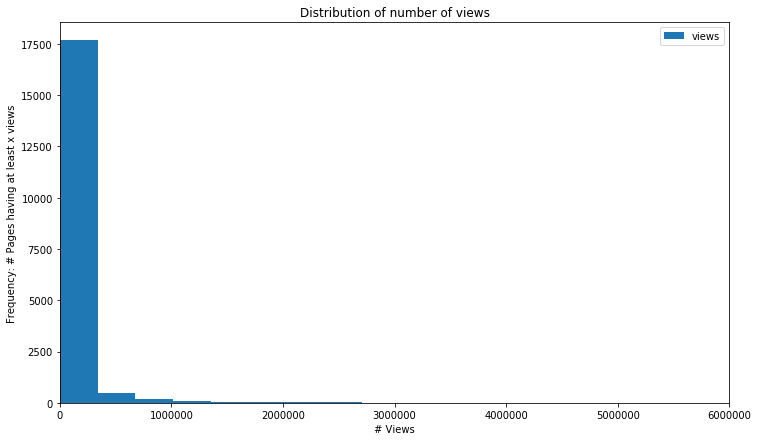

In [56]:
just_views_count = views_df.select('views').toPandas()
just_views_count.plot(kind="hist", bins=100, 
                     figsize=(12,7), title="Distribution of number of views")
plt.xlabel('# Views')
plt.ylabel('Frequency: # Pages having at least x views')
plt.xlim(0.0e7,0.6e7)
plt.show()

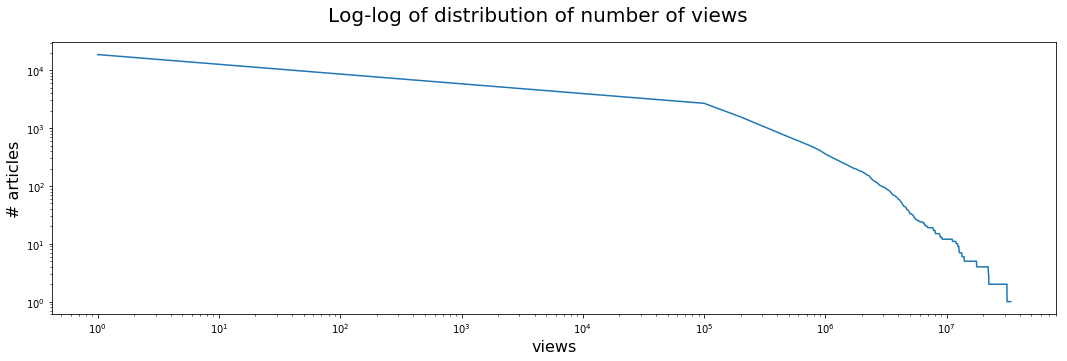

In [57]:
step = 100000;
xs = pd.Series(range(1,int(just_views_count.max()),step));
gratherThanData = xs.apply(lambda x: (just_views_count.views[just_views_count.views>=x]).count());

f, (ax2) = plt.subplots(1, 1);
plt.sca(ax2);
plt.plot(xs,gratherThanData);
plt.xlabel('views',fontsize=16);
plt.ylabel('# articles',fontsize=16);
plt.yscale('log'); plt.xscale('log');
f.set_size_inches(18, 5)
f.suptitle('Log-log of distribution of number of views',fontsize=20)
plt.show();

As seen we plotted our cumulative distribution in normal axes and in log-log axes. The distribution of the number of views follows a power law. Since it follows a power law, reporting mean or variance for a power-law-distributed data is not relevant as these statistics are not robust as they are sensitive to data. Instead, we use robust statistics and report the median and quartiles using boxplots. We compare boxplots with and without outliers.

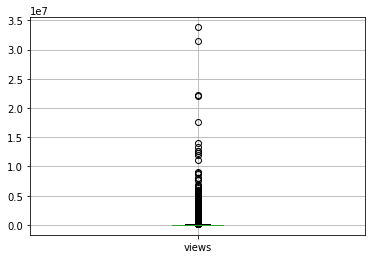

In [58]:
# with all data
just_views_count.boxplot();

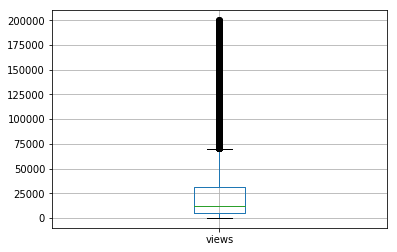

In [59]:
# without outliers
just_views_count[just_views_count['views'] < 200000].boxplot();

# Popularity metric 3

### Get number of external links per page
This was collected with the cluster. Script for running on the cluster found in `cluster/external_references.py`

# Popularity metric 4

### Get length of article 
We assume that the longer the article, the more popular it may be.

In [14]:
# Loading the data
WIKIPEDIA_LENGTH_PARQUET = DATA_DIR + "intermediate/wikipedia_no_outliers.parquet"

# loading the saved parquet files
articles = spark.read.parquet(WIKIPEDIA_LENGTH_PARQUET)
articles_length = articles.withColumn('article_lenght', F.length(articles.revision.text._VALUE))
articles_length_filter = articles_length.select("id","title","categories","article_lenght")
articles_length_filter.sort('article_lenght', ascending=False).show(5)

+--------+--------------------+--------------------+--------------+
|      id|               title|          categories|article_lenght|
+--------+--------------------+--------------------+--------------+
|52019122|Battle of Mosul (...|   military conflict|        636363|
|46230181|Saudi Arabian-led...|   military conflict|        434819|
|42563745|      War in Donbass|   military conflict|        393174|
| 6750583| History of Xinjiang|military conflict...|        364205|
| 3030955|    Kashmir conflict|   military conflict|        364091|
+--------+--------------------+--------------------+--------------+
only showing top 5 rows



**Distribution of article length** We bin the article length to get the number of pages having at least x article lengths. This is observed with a histogram plot.

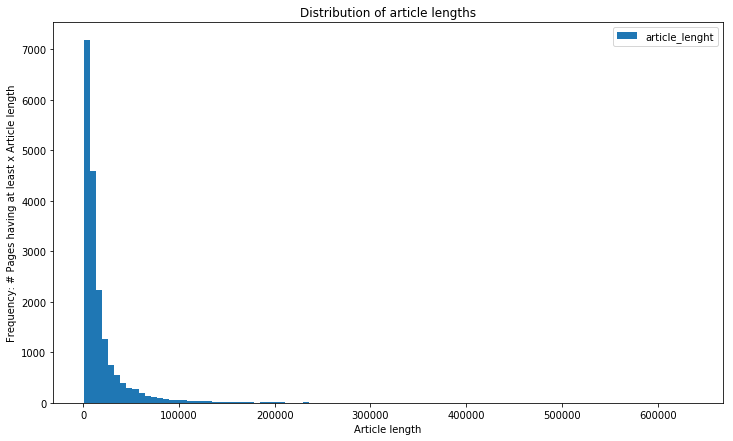

In [63]:
just_article_length = articles_length_filter.select('article_lenght').toPandas()
just_article_length.plot(kind="hist", bins=100, 
                     figsize=(12,7), title="Distribution of article lengths")
plt.xlabel('Article length')
plt.ylabel('Frequency: # Pages having at least x Article length')
plt.show()

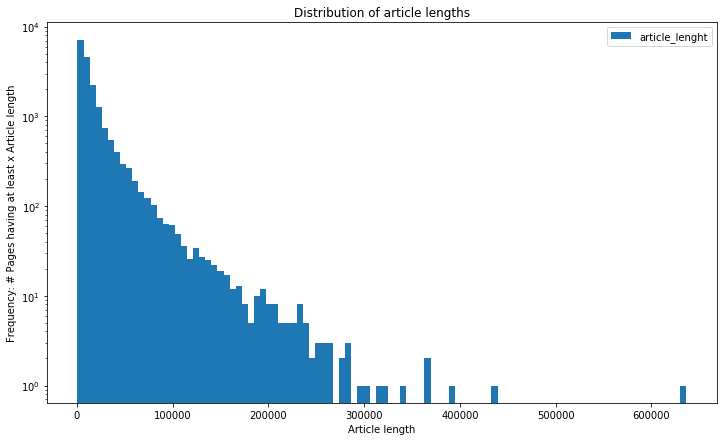

In [64]:
just_article_length = articles_length_filter.select('article_lenght').toPandas()
just_article_length.plot(kind="hist", bins=100, log = True,
                     figsize=(12,7), title="Distribution of article lengths")
plt.xlabel('Article length')
plt.ylabel('Frequency: # Pages having at least x Article length')
plt.show()

The distribution has a heavy-tailed distribution: it may follow a power law.

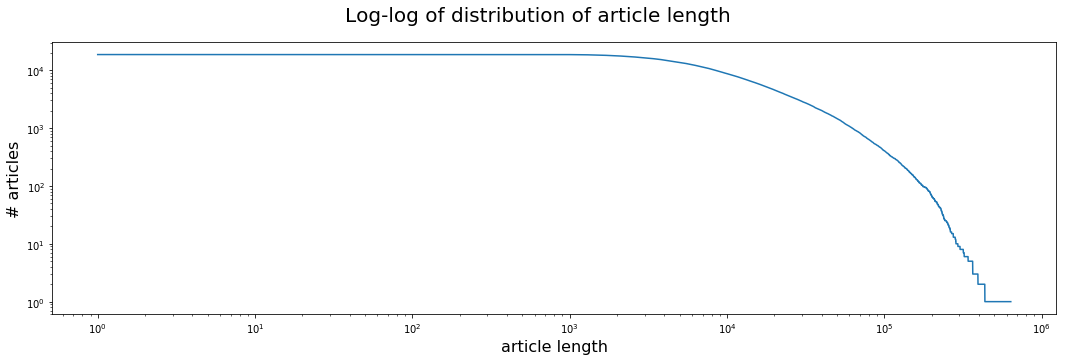

In [65]:
step = 100;
xs = pd.Series(range(1,int(just_article_length.max()),step));
gratherThanData = xs.apply(lambda x: (just_article_length.article_lenght[just_article_length.article_lenght>=x]).count());

f, (ax2) = plt.subplots(1, 1);
plt.sca(ax2);
plt.plot(xs,gratherThanData);
plt.xlabel('article length',fontsize=16);
plt.ylabel('# articles',fontsize=16);
plt.yscale('log'); plt.xscale('log');
f.set_size_inches(18, 5)
f.suptitle('Log-log of distribution of article length',fontsize=20)
plt.show();

# Save data before joins

Save the data that contain the metrics of popularity before joining them in a single table. Important to avoid to re run all notebook. external links will be loaded afterwards because very heavy to join directly on all data; better to join on catergories.

In [15]:
# external links will be loaded afterwards because very heav

# metric views
views_df.write.mode('overwrite').parquet(DATA_DIR+"intermediate/before_joins_views.parquet");
# metric ref
reference_count_page.write.mode('overwrite').parquet(DATA_DIR+"intermediate/before_joins_ref_counts.parquet");
# metric article length
articles_length_filter.write.mode('overwrite').parquet(DATA_DIR+"intermediate/before_joins_article_length.parquet");

---

# Joining tables on the page id

Having defined popularity metrics and importance criterion, we now join the tables on the page ID.

## 1. Join all popularity tables on page id

In [16]:
# need tables reference_count_page & articles_length_filter
references_popularity = reference_count_page.registerTempTable('references_popularity')
length_popularity = articles_length_filter.registerTempTable('length_popularity')
views_popularity = views_df.registerTempTable('views_popularity')

query_join_ref_length = """
select length_popularity.id, length_popularity.title, length_popularity.categories, length_popularity.article_lenght, references_popularity.refs_count
from length_popularity
join references_popularity
on length_popularity.id = references_popularity.id
"""

join_ref_length = spark.sql(query_join_ref_length)
join_ref_length.show(5)

+------+--------------------+--------------------+--------------+----------+
|    id|               title|          categories|article_lenght|refs_count|
+------+--------------------+--------------------+--------------+----------+
|  4823|         Balkan Wars|   military conflict|         56312|         8|
| 47928|   Battle of Naissus|   military conflict|         12440|        23|
| 50157|Battle of Stoke F...|   military conflict|         16061|        12|
|381602|    Baby Face Nelson|criminal, civilia...|         39762|        57|
|424102|Battle of Beachy ...|   military conflict|         21589|        26|
+------+--------------------+--------------------+--------------+----------+
only showing top 5 rows



In [17]:
# mini-test
join_ref_length.filter("title = 'Jahriyya revolt'").collect()

[Row(id=57214505, title='Jahriyya revolt', categories='military conflict', article_lenght=10027, refs_count=22)]

In [18]:
join_ref_length_sql = join_ref_length.registerTempTable('join_ref_length_sql')
query_join_popularity = """
select join_ref_length_sql.id, join_ref_length_sql.title, join_ref_length_sql.categories, join_ref_length_sql.article_lenght, views_popularity.views, join_ref_length_sql.refs_count  
from join_ref_length_sql
join views_popularity
on join_ref_length_sql.title = views_popularity.title
"""
popularity = spark.sql(query_join_popularity)
popularity.show(5)

+------+--------------------+--------------------+--------------+-------+----------+
|    id|               title|          categories|article_lenght|  views|refs_count|
+------+--------------------+--------------------+--------------+-------+----------+
|  4823|         Balkan Wars|   military conflict|         56312|1124826|         8|
| 47928|   Battle of Naissus|   military conflict|         12440|  56441|        23|
| 50157|Battle of Stoke F...|   military conflict|         16061| 113136|        12|
|381602|    Baby Face Nelson|criminal, civilia...|         39762|1927516|        57|
|424102|Battle of Beachy ...|   military conflict|         21589|  66081|        26|
+------+--------------------+--------------------+--------------+-------+----------+
only showing top 5 rows



## 2. Join each category table with popularity table

In [20]:
# need tables popularity, wiki_civil_conflict_df, wiki_civilian_attack_df, wiki_military_conflict_df
civil_conflict_df1 = spark.read.parquet(DATA_DIR + "intermediate/wiki_civil_conflict_df.parquet")
military_conflict_df1 = spark.read.parquet(DATA_DIR + "intermediate/wiki_military_conflict_df.parquet")
civilian_attack_df1 = spark.read.parquet(DATA_DIR + "intermediate/wiki_civilian_attack_df.parquet")

popularity_sql = popularity.registerTempTable('popularity_sql')
civil_conflict = civil_conflict_df1.registerTempTable('civil_conflict')
military_conflict = military_conflict_df1.registerTempTable('military_conflict')
civilian_attack = civilian_attack_df1.registerTempTable('civilian_attack')

**Join between popularity & `civil conflict`**

In [72]:
query_join_popularity_civil_conflict = """
select popularity_sql.id, popularity_sql.title, popularity_sql.categories, popularity_sql.article_lenght, popularity_sql.views, popularity_sql.refs_count, civil_conflict.death, civil_conflict.end_date, civil_conflict.location
from popularity_sql, civil_conflict
where popularity_sql.id = civil_conflict.id
"""

popularity_civil_conflict = spark.sql(query_join_popularity_civil_conflict)
popularity_civil_conflict.show(5)

+--------+--------------------+--------------+--------------+------+----------+--------------------+--------------------+--------------------+
|      id|               title|    categories|article_lenght| views|refs_count|               death|            end_date|            location|
+--------+--------------------+--------------+--------------+------+----------+--------------------+--------------------+--------------------+
|25827443|Long, hot summer ...|civil conflict|          4473| 28498|         4|                null|      Summer of 1967|   [[United States]]|
|34516509|2000 UEFA Cup Fin...|civil conflict|         26461| 73384|        51|                null|         17 May 2000|City Hall Square,...|
|36647928|Baltimore municip...|civil conflict|         39343|  6461|        49|'''Deaths''': <br...|+1974-07-14T00:00...|[[Baltimore, Mary...|
|49364124|Şırnak clashes (2...|civil conflict|         13430|  2701|        27|                null|August 2015-May 2016|[[Şırnak]], [[Tur...|

In [73]:
# saving binary file
popularity_civil_conflict.write.mode('overwrite').parquet(DATA_DIR+"popularity_civil_conflict.parquet");

**Join between popularity & `military conflict`**

In [21]:
query_join_popularity_military_conflict = """
select popularity_sql.id, popularity_sql.title, popularity_sql.categories, popularity_sql.article_lenght, popularity_sql.views, popularity_sql.refs_count, military_conflict.death, military_conflict.end_date, military_conflict.location
from popularity_sql, military_conflict
where popularity_sql.id = military_conflict.id
"""

popularity_military_conflict = spark.sql(query_join_popularity_military_conflict)
popularity_military_conflict.show(5)

+------+--------------------+-----------------+--------------+-------+----------+--------------------+--------------------+--------------------+
|    id|               title|       categories|article_lenght|  views|refs_count|               death|            end_date|            location|
+------+--------------------+-----------------+--------------+-------+----------+--------------------+--------------------+--------------------+
|  4823|         Balkan Wars|military conflict|         56312|1124826|         8|                null|+1913-07-18T00:00...|{{hlist |[[Adrian...|
| 47928|   Battle of Naissus|military conflict|         12440|  56441|        23|             unknown|          268 or 269|       Niš (Q129259)|
| 50157|Battle of Stoke F...|military conflict|         16061| 113136|        12|Unknown, estimate...|        16 June 1487|East Stoke, Notti...|
|424102|Battle of Beachy ...|military conflict|         21589|  66081|        26|       No ships lost|        10 July 1690|English

In [22]:
#check if join works
#popularity_military_conflict.select("title like '%World War II%'")
popularity_military_conflict.filter("title = 'World War II'").collect()

[Row(id=32927, title='World War II', categories='military conflict', article_lenght=223212, views=33835972, refs_count=238, death='+73000000', end_date='+1945-09-02T00:00:00Z', location='[Russia (Q159), Europe (Q46), Africa (Q15), Pacific Ocean (Q98), Mediterranean Sea (Q4918), Asia (Q48), Atlantic Ocean (Q97), Middle East (Q7204), Southeast Asia (Q11708), Scandinavia (Q21195)]')]

In [23]:
# saving binary file
popularity_military_conflict.write.mode('overwrite').parquet(DATA_DIR+"intermediate/popularity_military_conflict.parquet");

**Join between popularity & `civilian attack`**

In [77]:
query_join_popularity_civilian_attack = """
select popularity_sql.id, popularity_sql.title, popularity_sql.categories, popularity_sql.article_lenght, popularity_sql.views, popularity_sql.refs_count, civilian_attack.death, civilian_attack.end_date, civilian_attack.location
from popularity_sql, civilian_attack
where popularity_sql.id = civilian_attack.id
"""

popularity_civilian_attack = spark.sql(query_join_popularity_civilian_attack)
popularity_civilian_attack.show(5)

+--------+--------------------+--------------------+--------------+-------+----------+--------------------+--------------------+--------------------+
|      id|               title|          categories|article_lenght|  views|refs_count|               death|            end_date|            location|
+--------+--------------------+--------------------+--------------+-------+----------+--------------------+--------------------+--------------------+
|  381602|    Baby Face Nelson|criminal, civilia...|         39762|1927516|        57|                null|                null|                null|
|  464698|Massacres of Pole...|     civilian attack|        120291| 344457|       159|              +80000|+1944-00-00T00:00...|    Volhynia (Q7530)|
| 3177125|Springfield race ...|     civilian attack|        274021|  44412|       449|:16 (at least) 
*...|: August 14–16, 1908|: [[Springfield, ...|
| 9490463|  Mirusuvil massacre|     civilian attack|         11256|   4697|        17|              

In [78]:
# saving binary file
popularity_civilian_attack.write.mode('overwrite').parquet(DATA_DIR+"popularity_civilian_attack.parquet");

## 3. Join each category table with external links

In [24]:
# Loading the data
external_links_df = spark.read.parquet(DATA_DIR + "intermediate/external_links.parquet")
civilian_attack_minus_links_df = spark.read.parquet(DATA_DIR + "intermediate/popularity_civilian_attack.parquet")
military_conflict_minus_links_df = spark.read.parquet(DATA_DIR + "intermediate/popularity_military_conflict.parquet")
civil_conflict_minus_links_df = spark.read.parquet(DATA_DIR + "intermediate/popularity_civil_conflict.parquet")

In [25]:
# register as SQL view 
external_links = external_links_df.registerTempTable('external_links')
civilian_attack_minus_links = civilian_attack_minus_links_df.registerTempTable('civilian_attack_minus_links')
military_conflict_minus_links = military_conflict_minus_links_df.registerTempTable('military_conflict_minus_links')
civil_conflict_minus_links = civil_conflict_minus_links_df.registerTempTable('civil_conflict_minus_links')

**Join between external links & `civil conflict`**

In [102]:
# join civil conflict and external links on id 
query_join_links_civil_conflict = """
select civil_conflict_minus_links.id, civil_conflict_minus_links.title, civil_conflict_minus_links.categories, civil_conflict_minus_links.article_lenght, civil_conflict_minus_links.views, civil_conflict_minus_links.refs_count, external_links.link_count ,civil_conflict_minus_links.death, civil_conflict_minus_links.end_date, civil_conflict_minus_links.location
from civil_conflict_minus_links, external_links
where civil_conflict_minus_links.id = external_links.id
"""

civil_conflict_with_links = spark.sql(query_join_links_civil_conflict)
civil_conflict_with_links.show(5)


+--------+--------------------+--------------+--------------+------+----------+----------+-----+--------------------+--------------------+
|      id|               title|    categories|article_lenght| views|refs_count|link_count|death|            end_date|            location|
+--------+--------------------+--------------+--------------+------+----------+----------+-----+--------------------+--------------------+
|  637627|     Rose Revolution|civil conflict|         36387|212531|        44|       121| null|3&ndash;23 Novemb...|[[Georgia (countr...|
|29579740|2010 student prot...|civil conflict|         18501|  8757|        26|        85| null|     3 November 2010| [[Dublin]], Ireland|
|33699923|2011 Oakland gene...|civil conflict|         15602|  7599|        20|        33| null|{{Start date|2011...|[[Oakland, Califo...|
|43430546|2014 Saharanpur r...|civil conflict|          5219| 19968|         6|        19| null|{{Start date|df|=...|[[Saharanpur]], [...|
|44255559|2014 Burkinabé up

In [105]:
# saving binary file
civil_conflict_with_links.write.mode('overwrite').parquet(
    DATA_DIR+"All_popularity_metrics_civil_conflict.parquet"
);

**Join between external links & `military conflict`**

In [26]:
# join military conflict and external links on id 
query_join_links_military_conflict = """
select military_conflict_minus_links.id, military_conflict_minus_links.title, military_conflict_minus_links.categories, military_conflict_minus_links.article_lenght, military_conflict_minus_links.views, military_conflict_minus_links.refs_count, external_links.link_count ,military_conflict_minus_links.death, military_conflict_minus_links.end_date, military_conflict_minus_links.location
from military_conflict_minus_links, external_links
where military_conflict_minus_links.id = external_links.id
"""

military_conflict_with_links = spark.sql(query_join_links_military_conflict)
military_conflict_with_links.show(5)

+------+--------------------+-----------------+--------------+-------+----------+----------+--------------------+--------------------+--------------------+
|    id|               title|       categories|article_lenght|  views|refs_count|link_count|               death|            end_date|            location|
+------+--------------------+-----------------+--------------+-------+----------+----------+--------------------+--------------------+--------------------+
| 29328|         Six-Day War|military conflict|        170832|4808587|       190|       592|776–983 killed<br...|+1968-06-10T00:00...| Middle East (Q7204)|
| 36771|Battle of the Che...|military conflict|         47082| 289053|        78|       203|220 killed or wou...|    5 September 1781|off the [[Virgini...|
| 60117|          Juno Beach|military conflict|         71892| 496842|         0|       220|340 dead <br /> 5...|         6 June 1944|Courseulles-sur-M...|
| 68318| Battle of the Boyne|military conflict|         29669|11

In [27]:
# saving binary file
military_conflict_with_links.write.mode('overwrite').parquet(
    DATA_DIR+"All_popularity_metrics_military_conflict.parquet"
);

**Join between external links & `civilian attack`**

In [109]:
# join civil conflict and external links on id 
query_join_links_civilian_attack = """
select civilian_attack_minus_links.id, civilian_attack_minus_links.title, civilian_attack_minus_links.categories, civilian_attack_minus_links.article_lenght, civilian_attack_minus_links.views, civilian_attack_minus_links.refs_count, external_links.link_count ,civilian_attack_minus_links.death, civilian_attack_minus_links.end_date, civilian_attack_minus_links.location
from civilian_attack_minus_links, external_links
where civilian_attack_minus_links.id = external_links.id
"""
civilian_attack_with_links = spark.sql(query_join_links_civilian_attack)
civilian_attack_with_links.show(5)


+--------+--------------------+---------------+--------------+-----+----------+----------+-----+--------------------+--------------------+
|      id|               title|     categories|article_lenght|views|refs_count|link_count|death|            end_date|            location|
+--------+--------------------+---------------+--------------+-----+----------+----------+-----+--------------------+--------------------+
|  317460|1986 West Berlin ...|civilian attack|          9356|73773|        13|        58|   +3|{{Start date and ...|La Belle (Q28146472)|
|30319497|Marburg's Bloody ...|civilian attack|         26797|11431|        30|        63| 9–13|     27 January 1919|                null|
|31297671|1994 British Army...|civilian attack|          8330|57237|        13|        71| null|       20 March 1994|Crossmaglen (Q183...|
|31771514|2011 Manhattan te...|civilian attack|         10108|21929|        10|        50| null|Suspects arrested...|  Manhattan (Q11299)|
|36450267|     Bagber massa

In [110]:
# saving binary file
civilian_attack_with_links.write.mode('overwrite').parquet(
    DATA_DIR+"All_popularity_metrics_civilian_attack.parquet"
);

In [112]:
# check # ele in file
print('Civilian attack: {}'.format(civilian_attack_with_links.count()))
print('Military conflict: {}'.format(military_conflict_with_links.count()))
print('Civil conflict: {}'.format(civil_conflict_with_links.count()))
print('Total number of articles: {}'.format(civilian_attack_with_links.count()
                                            + military_conflict_with_links.count() + 
                                            civil_conflict_with_links.count()))

Civilian attack: 2468
Military conflict: 14158
Civil conflict: 847
Total number of articles: 17473


# 4. Concatenate all 3 categories into 1 single file

In [30]:
# load all before concat
civilian_attack_with_links = spark.read.parquet(
    DATA_DIR + "All_popularity_metrics_civilian_attack.parquet"
)
military_conflict_with_links = spark.read.parquet(
    DATA_DIR + "All_popularity_metrics_military_conflict.parquet"
)
civil_conflict_with_links = spark.read.parquet(
    DATA_DIR + "All_popularity_metrics_civil_conflict.parquet"
)

In [31]:
FINAL_civilian_attack = civilian_attack_with_links.registerTempTable('FINAL_civilian_attack')
FINAL_military_conflict = military_conflict_with_links.registerTempTable('FINAL_military_conflict')
FINAL_civil_conflict = civil_conflict_with_links.registerTempTable('FINAL_civil_conflict')

# UNION 3 categories
query_union_3_cat = """
select *
from FINAL_civilian_attack
union 
select *
from FINAL_military_conflict
union
select *
from FINAL_civil_conflict
"""
union_3_cat = spark.sql(query_union_3_cat)
union_3_cat.show(5)


+--------+--------------------+--------------------+--------------+------+----------+----------+-----+--------------------+--------------------+
|      id|               title|          categories|article_lenght| views|refs_count|link_count|death|            end_date|            location|
+--------+--------------------+--------------------+--------------+------+----------+----------+-----+--------------------+--------------------+
|57662956|2004 Lahsuna mass...|     civilian attack|          2013|  1296|         2|        11|    4|                null|Lahsuna, [[Bihar]...|
|41448938|December 2013 Man...|     civilian attack|         15569|  6678|        28|        36|  +16|{{Start date|2013...|  Mansoura (Q223587)|
|44028252|  2014 Burdwan blast|     civilian attack|          6075| 11950|         6|        18|   +2|      2 October 2014| Bardhaman (Q709267)|
|57863938| 1988 Naples bombing|     civilian attack|          4851|  1476|         7|        35|    5|       14 April 1988|[[Naple

In [32]:
print('Total number of articles after union: {}'.format(union_3_cat.count()))

Total number of articles after union: 17468


In [33]:
# saving binary file
union_3_cat.write.mode('overwrite').parquet(DATA_DIR+"union_3_cat.parquet");

# Cleaning

In [48]:
def quantify_nans(spark_df: dataframe.DataFrame, plot=True):
    # Quantifying null values
    # how many rows does the dataframe have?
    mili_rows=spark_df.count()

    mili_nan = spark_df.select([
        F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in spark_df.columns
    ]).toPandas()

    mili_percentages_nan = mili_nan*100/mili_rows
    print(mili_percentages_nan)
    print('{} is the percentage of nan values in {}'.format([ele for ele in mili_percentages_nan.values.tolist()], spark_df.columns))
    
    if plot:
        sns.barplot(data=mili_percentages_nan, palette='RdBu',orient='h')

In [49]:
# load filtered articles (parquet)
conflict_articles = spark.read.parquet(DATA_DIR + "union_3_cat.parquet/")
conflict_articles.count()

17468

   location  end_date      death
0  0.973208  2.438745  27.295626
[[0.9732081520494619, 2.4387451339592396, 27.295626288069613]] is the percentage of nan values in ['location', 'end_date', 'death']


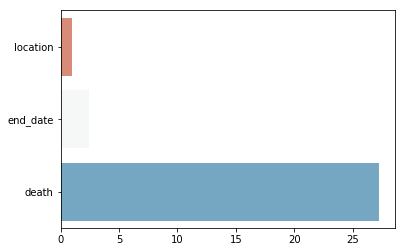

In [50]:
quantify_nans(conflict_articles.select(['location', 'end_date', 'death']))

In [51]:
df_articles = conflict_articles.toPandas().set_index('id')
df_articles.head()

,title,categories,article_lenght,views,refs_count,link_count,death,end_date,location
id,,,,,,,,,
19896366,2008 Imphal bombing,civilian attack,19719,5617,20,38,17,21 October 2008,Imphal (Q208097)
2234230,Savoy Hotel attack,civilian attack,10713,11059,9,45,"8 civilian hostages, 3 Israeli soldiers, 7 [[F...",+1975-03-05T00:00:00Z,Tel Aviv (Q33935)
46935886,1993 Aurora shooting,"civilian attack, criminal",10075,271842,11,52,4,"December 14, 1993","12293 East Iliff Avenue,<br/>[[Aurora, Colorad..."
38247068,In Amenas hostage crisis,civilian attack,55589,99062,106,128,"At least 67 (at least 37 foreign hostages, an ...",None,"West of [[In Amenas]], Algeria"
12983993,1984 Montreal bombing,civilian attack,21695,550,24,100,3,"September 3, 1984","[[Montreal]], [[Quebec]], [[Canada]]"


### Location 

In [52]:
location = clean_location(df_articles)
location.head()

771     Eastern  North  America|Caribbean  Sea|Indian ...
863     Southern  United  States  Q49042|Northern  Uni...
3793    Ambion  Hill  Q4741491|Battle  of  Bosworth  F...
4005                                     Farsala  Q985596
4049                                   Blindheim  Q514914
Name: locations, dtype: object

In [53]:
# join serie with raw data on idex
joined = df_articles.join(location)
joined.drop(columns="location", inplace=True)
joined.head()

,title,categories,article_lenght,views,refs_count,link_count,death,end_date,locations
771,American Revolutionary War,military conflict,238972,8794983,598,924,"'''United States:'''<br />\n<small>25,000–70,0...",+1783-09-03T00:00:00Z,Eastern North America|Caribbean Sea|Indian ...
863,American Civil War,military conflict,203619,17696187,212,776,"{{plainlist|\n*110,000+ killed in action/died ...",+1865-05-10T00:00:00Z,Southern United States Q49042|Northern Uni...
3793,Battle of Bosworth Field,military conflict,97380,1107588,34,305,unknown,22 August 1485,Ambion Hill Q4741491|Battle of Bosworth F...
4005,Battle of Pharsalus,military conflict,22469,601822,20,99,~230 (according to Caesar),9 August 48 BC,Farsala Q985596
4049,Battle of Blenheim,military conflict,66889,458284,95,201,"'''12,484'''<br />4,542 killed<br />7,942 wounded",13 August 1704,Blindheim Q514914


In [54]:
artictles = joined
artictles.head()

,title,categories,article_lenght,views,refs_count,link_count,death,end_date,locations
771,American Revolutionary War,military conflict,238972,8794983,598,924,"'''United States:'''<br />\n<small>25,000–70,0...",+1783-09-03T00:00:00Z,Eastern North America|Caribbean Sea|Indian ...
863,American Civil War,military conflict,203619,17696187,212,776,"{{plainlist|\n*110,000+ killed in action/died ...",+1865-05-10T00:00:00Z,Southern United States Q49042|Northern Uni...
3793,Battle of Bosworth Field,military conflict,97380,1107588,34,305,unknown,22 August 1485,Ambion Hill Q4741491|Battle of Bosworth F...
4005,Battle of Pharsalus,military conflict,22469,601822,20,99,~230 (according to Caesar),9 August 48 BC,Farsala Q985596
4049,Battle of Blenheim,military conflict,66889,458284,95,201,"'''12,484'''<br />4,542 killed<br />7,942 wounded",13 August 1704,Blindheim Q514914


### Date

In [55]:
artictles['end_date'] = artictles['end_date'].astype('str')

In [56]:
artictles['end_date_clean'] = artictles['end_date'].apply(find_pattern)

In [57]:
artictles.drop(columns=['end_date'], inplace=True)
artictles['end_date_clean'] = artictles['end_date_clean'].astype('str')
artictles.head()

,title,categories,article_lenght,views,refs_count,link_count,death,locations,end_date_clean
771,American Revolutionary War,military conflict,238972,8794983,598,924,"'''United States:'''<br />\n<small>25,000–70,0...",Eastern North America|Caribbean Sea|Indian ...,1783
863,American Civil War,military conflict,203619,17696187,212,776,"{{plainlist|\n*110,000+ killed in action/died ...",Southern United States Q49042|Northern Uni...,1865
3793,Battle of Bosworth Field,military conflict,97380,1107588,34,305,unknown,Ambion Hill Q4741491|Battle of Bosworth F...,1485
4005,Battle of Pharsalus,military conflict,22469,601822,20,99,~230 (according to Caesar),Farsala Q985596,None
4049,Battle of Blenheim,military conflict,66889,458284,95,201,"'''12,484'''<br />4,542 killed<br />7,942 wounded",Blindheim Q514914,1704


In [58]:
artictles['end_date_clean'].describe()

count     17468
unique     1618
top        None
freq        579
Name: end_date_clean, dtype: object

In [59]:
print('ongoing conflics: {}'.format(artictles['end_date_clean'][artictles['end_date_clean'] == 'ongoing'].count()))
artictles[artictles['end_date_clean'] == 'ongoing']

ongoing conflics: 32


,title,categories,article_lenght,views,refs_count,link_count,death,locations,end_date_clean
85482,Scientology and the Internet,civil conflict,51232,63630,71,249,None,Internet|courts of law|worldwide protests,ongoing
3030955,Kashmir conflict,military conflict,364091,2483943,519,790,None,Kashmir Q43100,ongoing
6020082,Israeli–Lebanese conflict,military conflict,76024,326679,130,311,"1,900 killed Lebanese factions<br />11,000 kil...",Israel Q801,ongoing
7960202,Arab–Israeli conflict,military conflict,97572,1209791,137,415,"≈22,570 military deaths ≈1,723 civilian deaths...",Middle East Q7204,ongoing
8812611,Operation Enduring Freedom – Horn of Africa,military conflict,58433,167555,94,170,{{Flagu|United States}} <br />2 killed in acti...,Horn of Africa Q40556,ongoing
9365263,Operation Juniper Shield,military conflict,21516,14968,37,95,None,Sahara Q6583,ongoing
16346266,Gaza–Israel conflict,military conflict,88749,455401,165,312,~100 killed,hlist Gaza Strip Southern District Israel ...,ongoing
16475950,Operation Lion's Leap,military conflict,3922,4369,4,15,None,Diwaniya|Iraq,ongoing
18695217,Operation Michoacán,military conflict,15083,27471,23,71,50 soldiers killed<br>100 police officers killed,Michoacán Q79861,ongoing
28049183,Political killings in the Philippines (2001–10),civilian attack,28331,26669,29,174,+1200,Philippines Q928,ongoing


In [60]:
def find_ongoing(my_str: str) -> bool:
    ongoing = re.compile(r"ongoing", re.IGNORECASE)
    if re.search(ongoing, my_str):
        return True
    # else return False
    return False

In [61]:
# create a new categorical feature with the ongoing conflicts
artictles['end_date_clean'] = artictles['end_date_clean'].astype('str')
artictles['ongoing'] = artictles['end_date_clean'].apply(find_ongoing)
artictles.head()

,title,categories,article_lenght,views,refs_count,link_count,death,locations,end_date_clean,ongoing
771,American Revolutionary War,military conflict,238972,8794983,598,924,"'''United States:'''<br />\n<small>25,000–70,0...",Eastern North America|Caribbean Sea|Indian ...,1783,False
863,American Civil War,military conflict,203619,17696187,212,776,"{{plainlist|\n*110,000+ killed in action/died ...",Southern United States Q49042|Northern Uni...,1865,False
3793,Battle of Bosworth Field,military conflict,97380,1107588,34,305,unknown,Ambion Hill Q4741491|Battle of Bosworth F...,1485,False
4005,Battle of Pharsalus,military conflict,22469,601822,20,99,~230 (according to Caesar),Farsala Q985596,None,False
4049,Battle of Blenheim,military conflict,66889,458284,95,201,"'''12,484'''<br />4,542 killed<br />7,942 wounded",Blindheim Q514914,1704,False


In [62]:
# convert into numeric
artictles['end_date_clean'] = pd.to_numeric(artictles['end_date_clean'], errors='coerce')
artictles['end_date_clean'].describe()

count    1.685700e+04
mean     5.932255e+09
std      7.702112e+11
min      1.900000e+01
25%      1.740000e+03
50%      1.912000e+03
75%      1.975000e+03
max      1.000000e+14
Name: end_date_clean, dtype: float64

In [63]:
artictles.end_date_clean.isna().sum()

611

In [64]:
artictles.head()

,title,categories,article_lenght,views,refs_count,link_count,death,locations,end_date_clean,ongoing
771,American Revolutionary War,military conflict,238972,8794983,598,924,"'''United States:'''<br />\n<small>25,000–70,0...",Eastern North America|Caribbean Sea|Indian ...,1783.0,False
863,American Civil War,military conflict,203619,17696187,212,776,"{{plainlist|\n*110,000+ killed in action/died ...",Southern United States Q49042|Northern Uni...,1865.0,False
3793,Battle of Bosworth Field,military conflict,97380,1107588,34,305,unknown,Ambion Hill Q4741491|Battle of Bosworth F...,1485.0,False
4005,Battle of Pharsalus,military conflict,22469,601822,20,99,~230 (according to Caesar),Farsala Q985596,NaN,False
4049,Battle of Blenheim,military conflict,66889,458284,95,201,"'''12,484'''<br />4,542 killed<br />7,942 wounded",Blindheim Q514914,1704.0,False


In [65]:
# TV serie...
artictles[artictles['end_date_clean'] == artictles['end_date_clean'].max()]

,title,categories,article_lenght,views,refs_count,link_count,death,locations,end_date_clean,ongoing
2150520,Time War (Doctor Who),military conflict,66844,333172,78,344,None,Whoniverse Q3567870,1.000000e+14,False


In [66]:
artictles[artictles['end_date_clean'] > 2019]

,title,categories,article_lenght,views,refs_count,link_count,death,locations,end_date_clean,ongoing
62713,First Anglo-Dutch War,military conflict,30321,158507,12,151,"About 3,000 killed<br />33 warships sunk<br />...",English channel Q34640,2.199000e+03,False
160664,War of the Ring,military conflict,18826,156467,0,173,None,Middle- earth Q79734,3.019000e+03,False
205658,Battle of Wolf 359,military conflict,4951,197644,6,48,"39 ships destroyed, 11,000 killed or assimilated",Wolf 359 Q291301,2.367000e+03,False
207630,Dominion War,military conflict,89151,188209,100,559,Unknown,Primarily the Galactic quadrant Alpha and ...,2.375000e+03,False
2150520,Time War (Doctor Who),military conflict,66844,333172,78,344,None,Whoniverse Q3567870,1.000000e+14,False
2206127,Morgan's Raid,military conflict,27911,133069,14,166,"6,000 prisoners paroled",Tennessee Q1509,1.026174e+06,False
4778746,Battle of Banquan,military conflict,4604,45957,1,46,None,Banquan|China disputed,2.500000e+03,False
4902525,Battle of Zhuolu,military conflict,7647,44547,1,57,"~1,200–3,000",Zhuolu County Q198235,2.500000e+03,False
16315254,Second Battle of Beruna,military conflict,11516,13202,4,95,Unknown,Outside Aslan s How,2.303000e+03,False


In [67]:
# remove all conlficts that are greather than 2019 but keep nan
artictles = artictles[(artictles['end_date_clean'] < 2019) | (artictles['end_date_clean'].isna())]
artictles['end_date_clean'].describe()

count    16848.000000
mean      1747.511871
std        403.200965
min         19.000000
25%       1739.000000
50%       1912.000000
75%       1975.000000
max       2018.000000
Name: end_date_clean, dtype: float64

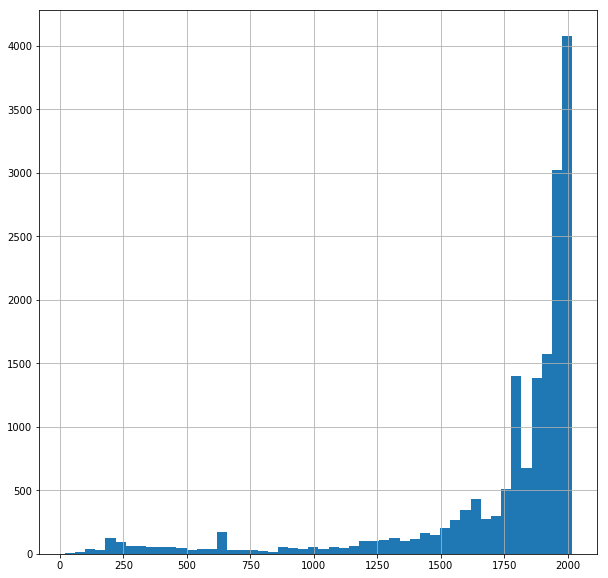

In [68]:
artictles['end_date_clean'].hist(figsize=(10, 10), bins=50);

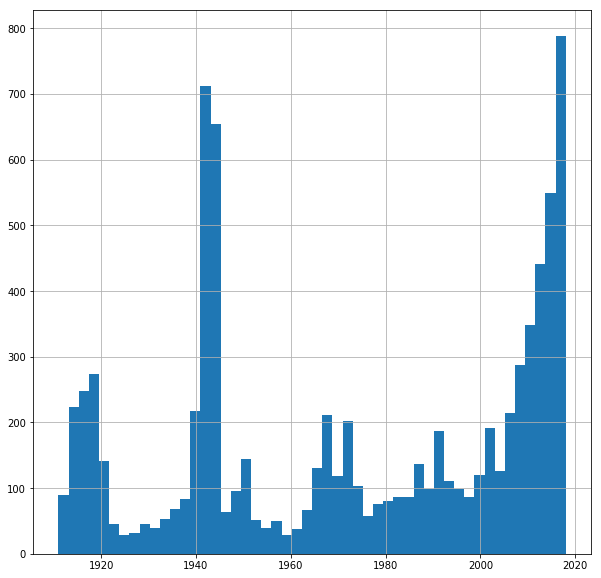

In [69]:
artictles['end_date_clean'][artictles['end_date_clean'] > 1910].hist(figsize=(10, 10), bins=50);

First peak  --> 1st World War

Second peak --> 2dn World War

Third peak  --> Today

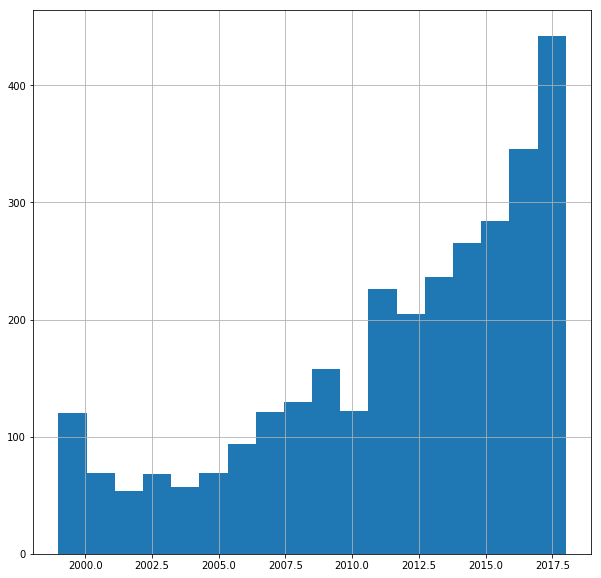

In [70]:
artictles['end_date_clean'][artictles['end_date_clean'] > 1998].hist(figsize=(10, 10), bins=18);

In [71]:
artictles.head()

,title,categories,article_lenght,views,refs_count,link_count,death,locations,end_date_clean,ongoing
771,American Revolutionary War,military conflict,238972,8794983,598,924,"'''United States:'''<br />\n<small>25,000–70,0...",Eastern North America|Caribbean Sea|Indian ...,1783.0,False
863,American Civil War,military conflict,203619,17696187,212,776,"{{plainlist|\n*110,000+ killed in action/died ...",Southern United States Q49042|Northern Uni...,1865.0,False
3793,Battle of Bosworth Field,military conflict,97380,1107588,34,305,unknown,Ambion Hill Q4741491|Battle of Bosworth F...,1485.0,False
4005,Battle of Pharsalus,military conflict,22469,601822,20,99,~230 (according to Caesar),Farsala Q985596,NaN,False
4049,Battle of Blenheim,military conflict,66889,458284,95,201,"'''12,484'''<br />4,542 killed<br />7,942 wounded",Blindheim Q514914,1704.0,False


In [72]:
artictles.isna().sum()

title                0
categories           0
article_lenght       0
views                0
refs_count           0
link_count           0
death             4765
locations          170
end_date_clean     611
ongoing              0
dtype: int64

In [73]:
artictles.isnull().sum()

title                0
categories           0
article_lenght       0
views                0
refs_count           0
link_count           0
death             4765
locations          170
end_date_clean     611
ongoing              0
dtype: int64

### Death

In [3]:
artictles = pd.read_csv(DATA_DIR + 'data_processed_before_death_cleaning.csv', index_col=0)
artictles.index.names = ['id']

In [4]:
def extract_deaths(_raw_str):    
    raw_str = re.sub(r'{.*?}','',str(_raw_str)) # questo è estremo, ne abbiamo veramente bisogno?
    raw_str = re.sub(r'<ref.*?(/>|</ref>)','',str(_raw_str))
    raw_str = re.sub(r'isbn=\d{1,99}|{isbn[|]\d.*?}', '', raw_str)
    raw_str = re.sub(r"(?:(?:https?|ftp):\/\/|\b(?:[a-z\d]+\.))(?:(?:[^\s()<>]+|\((?:[^\s()<>]+|(?:\([^\s()<>]+\)))?\))+(?:\((?:[^\s()<>]+|(?:\(?:[^\s()<>]+\)))?\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))?", '', raw_str)
    raw_str = re.sub(r"\|\d{1,9}\||\|\d{1,9}\.\d{1,9}em\||\d{1,9}\.\d{1,9}em\||page.\d{1,9}|p\..\d{1,9}",'',raw_str)
    raw_str = raw_str.replace(".",",")
    raw_str = raw_str.replace("+","")
    raw_str = raw_str.replace(" million","000000 ")
    raw_str = raw_str.replace(" housand","000")
    raw_str = raw_str.replace(" hundred","00")
    raw_str = re.sub(r"\d{1,9}((,|')\d{3})(.\d+)?([-–]| to | [-–] | [-–])\d{1,9}((,|')\d{3})([,']\d+)?(\s|[A-z])*displaced|\d{3}([-–]| to | [-–] | [-–])\d{3}([,']\d+)?(\s|[A-z])*displaced",'',raw_str)
    raw_str = re.sub(r"\d{1,9}((,|')\d{3})*(\.\d+)?(\s|[A-z])*displaced",'',raw_str)
    
    regex_nbrs = re.compile(r"\d{1,9}((,|')\d{3})*(\.\d+)?")
    regex_casu1 = re.compile(r".*\|caus2\|")
    regex_casu2 = re.compile(r"\|caus2\|.*")
    regex_rngs = re.compile(r"\d{1,9}((,|')\d{3})(.\d+)?([-–]| to | [-–] | [-–])\d{1,9}((,|')\d{3})([,']\d+)?|\d{3}([-–]| to | [-–] | [-–])\d{3}([,']\d+)?")
    
    if(raw_str == 0):
        return 0;
    
    def extractAllExtr(stringa):
        allExtr = [];
        for match in regex_nbrs.finditer(stringa):
            allExtr.append(match.group(0))
        
        if(len(allExtr) < 1):
            return 0

        rng1 = -1
        rng2 = -1
        for match in regex_rngs.finditer(stringa):
            rng = match.group(0)
            rng_split = (rng.replace(',','')
                            .replace("'","")
                            .replace("–","-")
                            .replace(" - ","-")
                            .replace(" to ","-").split("-"))
            rng1 = int(rng_split[0])
            rng2 = int(rng_split[1])
            if(rng1>=rng2):
                continue

            rng_sum = str(int((int(rng_split[0])+int(rng_split[1]))/2));
            allExtr.append(rng_sum)

        #cleaning: 
        #allExtr = [ x for x in allExtr if "." not in x ]
        allExtr = [extr.replace(',', '').replace("'","") for extr in allExtr]
        allExtr = [int(i) for i in allExtr]
        allExtr = [ x for x in allExtr if x not in [rng1,rng2] ]

        if(len(allExtr) == 1):
            return allExtr[0]

        def shouldGetMax(stringa,lenExtr):
            toExclude = re.compile(r"(at least|total|over [0-9])",re.IGNORECASE)
            if(toExclude.search(stringa)):
                return True
            if(lenExtr >=5): #5 numero arbitrario
                return True
            return False

        if shouldGetMax(stringa, len(allExtr)):
            return max(allExtr)

        return sum(i for i in allExtr)
    
    if(regex_casu2.search(raw_str)):
        casu1Deaths = regex_casu1.search(raw_str)
        casu1Deaths = extractAllExtr(casu1Deaths.group(0))
        
        casu2Deaths = regex_casu2.search(raw_str)
        casu2Deaths = extractAllExtr(casu2Deaths.group(0))
        
        casuAllDeaths = casu1Deaths+casu2Deaths
        return casuAllDeaths
    
    casuAllDeaths = extractAllExtr(raw_str)
    return casuAllDeaths

In [5]:
artictles["death"] = artictles["death"].apply(extract_deaths)

In [6]:
artictles.sort_values(by=['death'],ascending=False)

,title,categories,article_lenght,views,refs_count,link_count,death,locations,end_date_clean,ongoing
id,,,,,,,,,,
32927,World War II,military conflict,223212.0,33835972.0,238.0,1456.0,73000000,Russia Q159|Europe Q46|Africa Q15|Pacific ...,1945.0,False
342641,Pacific War,military conflict,184278.0,2656274.0,190.0,855.0,26000000,Pacific Ocean Q98|Indian Ocean Q1239|East ...,1945.0,False
42415336,Insurgency in Paraguay,military conflict,33018.0,13037.0,59.0,82.0,24062015,Northern Paraguay Amambay Department Caninde...,2005.0,False
4764461,World War I,military conflict,284173.0,31481685.0,254.0,1253.0,17000000,Europe Q46|Australia and Oceania Q55643|Mi...,1918.0,False
52166101,Mass killings of landlords under Mao Zedong,civilian attack,13778.0,82440.0,18.0,84.0,13875000,People s Republic of China Q148,1976.0,False
69980,Second Sino-Japanese War,military conflict,157821.0,3596111.0,185.0,737.0,10600000,Mainland China Q19188,1945.0,False
1120226,Japanese war crimes,civilian attack,155261.0,2004280.0,183.0,614.0,8500000,In and around East Asia and the Pacific,NaN,False
35053080,"Western Front tactics, 1917",military conflict,152391.0,22484.0,0.0,204.0,7947000,Belgium Q31,1918.0,False
51499,Western Front (World War I),military conflict,83636.0,1574450.0,0.0,279.0,7500000,Alsace- Lorraine Q155144|Belgium Q31|France ...,1918.0,False


In [7]:
artictles[(artictles.end_date_clean>=1995) & (artictles.death == 0)].count()

title             790
categories        790
article_lenght    790
views             790
refs_count        790
link_count        790
death             790
locations         775
end_date_clean    790
ongoing           790
dtype: int64

In [8]:
artictles[(artictles.end_date_clean>=1995)].count()

title             3252
categories        3252
article_lenght    3252
views             3252
refs_count        3252
link_count        3252
death             3252
locations         3210
end_date_clean    3252
ongoing           3252
dtype: int64

790 su 3252 non è male dai........

In [9]:
artictles.to_csv(DATA_DIR + 'data_processed.csv')

# Metric 

In [10]:
articles = pd.read_csv(DATA_DIR + 'data_processed.csv', index_col=0)
articles.index.names = ['id']
articles.head()
articles.end_date_clean = articles.end_date_clean.fillna(0)

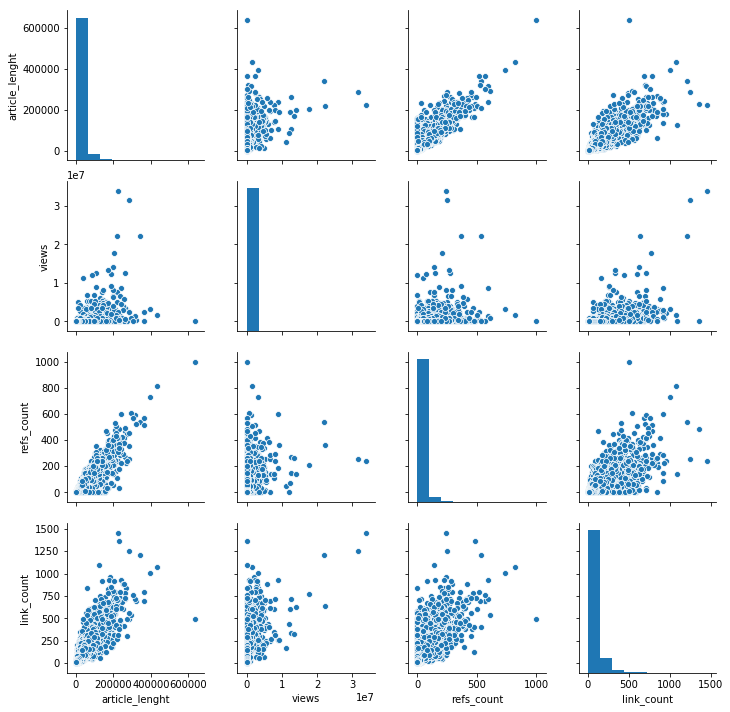

In [18]:
sns.pairplot(data=articles, vars=['article_lenght', 'views', 'refs_count', 'link_count']);

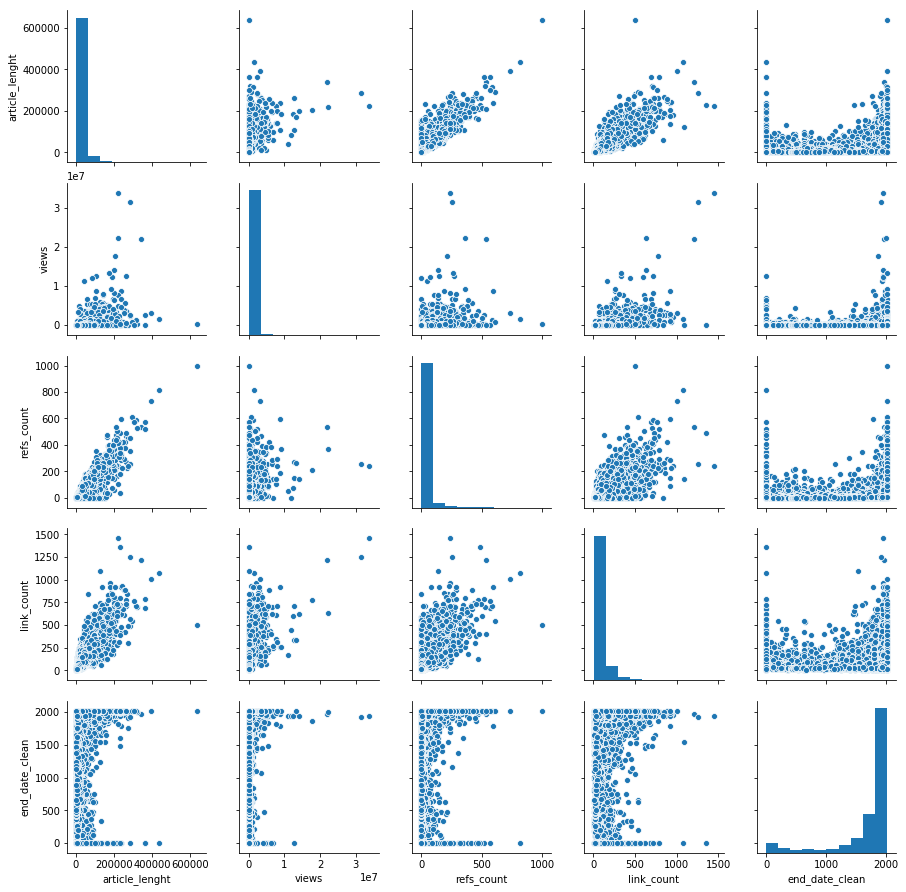

In [19]:
sns.pairplot(data=articles, vars=['article_lenght', 'views', 'refs_count', 'link_count', 'end_date_clean']);

In [11]:
min_max_scaler = MinMaxScaler(feature_range=(0,1))
articles_minmax = min_max_scaler.fit_transform(articles[['article_lenght', 'views', 'refs_count', 'link_count']])


In [12]:
articles_minmax

array([[3.75011206e-01, 2.59929068e-01, 5.98000000e-01, 6.34364261e-01],
       [3.19410478e-01, 5.22998643e-01, 2.12000000e-01, 5.32646048e-01],
       [1.52325203e-01, 3.27328661e-02, 3.40000000e-02, 2.08934708e-01],
       ...,
       [1.88727614e-03, 2.68944868e-06, 1.00000000e-03, 1.51202749e-02],
       [1.21100219e-03, 3.48741697e-06, 2.00000000e-03, 8.24742268e-03],
       [4.06393462e-03, 1.98014353e-06, 2.00000000e-03, 1.16838488e-02]])

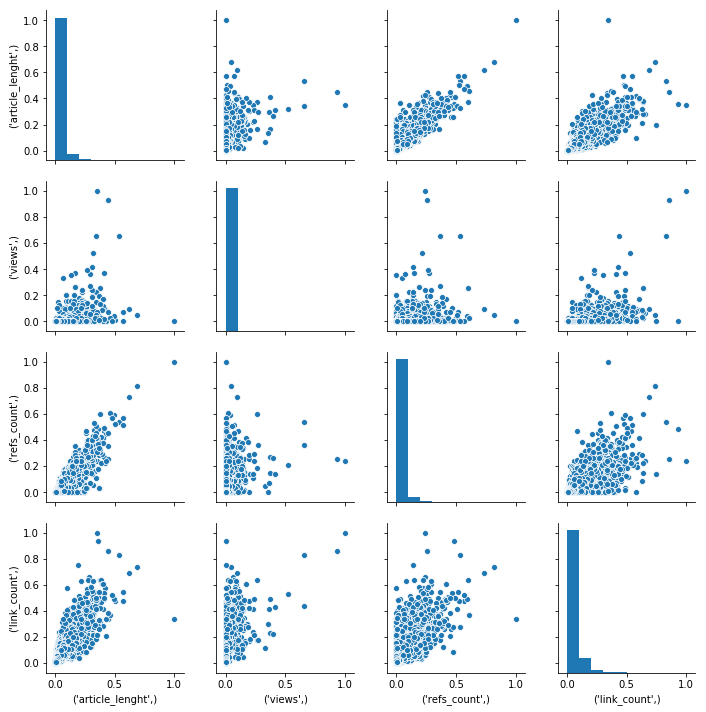

In [22]:
sns.pairplot(pd.DataFrame(articles_minmax, columns=[['article_lenght', 'views', 'refs_count', 'link_count']]));

In [13]:
articles[['article_lenght', 'views', 'refs_count', 'link_count']] = articles_minmax
articles.head()

,title,categories,article_lenght,views,refs_count,link_count,death,locations,end_date_clean,ongoing
id,,,,,,,,,,
771,American Revolutionary War,military conflict,0.375011,0.259929,0.598,0.634364,70000,Eastern North America|Caribbean Sea|Indian ...,1783.0,False
863,American Civil War,military conflict,0.319410,0.522999,0.212,0.532646,828000,Southern United States Q49042|Northern Uni...,1865.0,False
3793,Battle of Bosworth Field,military conflict,0.152325,0.032733,0.034,0.208935,0,Ambion Hill Q4741491|Battle of Bosworth F...,1485.0,False
4005,Battle of Pharsalus,military conflict,0.034510,0.017785,0.020,0.067354,230,Farsala Q985596,0.0,False
4049,Battle of Blenheim,military conflict,0.104371,0.013543,0.095,0.137457,24968,Blindheim Q514914,1704.0,False


# Define popularity score

## Normalisation

For each article *x*, the popularity score is defined as:

$score(x) = length(x) + views(x) + refs(x) + links(x)$

Where each feature, i.e. length views reds and links, has been normalized using the MinMax scaler:

$ std = \frac{feature_i - min(feature_i)}{max(feature_i) - min(feature_i)}$
$feature_i = std \dot ($

$\frac{a}{b}$

In [14]:
normalisation_factor = articles['article_lenght'].sum() + articles['views'].sum() \
                                + articles['refs_count'].sum() + articles['link_count'].sum()
articles['popularity_score'] = articles['article_lenght'] + articles['views'] \
                                + articles['refs_count'] + articles['link_count']

In [15]:
articles.head()

,title,categories,article_lenght,views,refs_count,link_count,death,locations,end_date_clean,ongoing,popularity_score
id,,,,,,,,,,,
771,American Revolutionary War,military conflict,0.375011,0.259929,0.598,0.634364,70000,Eastern North America|Caribbean Sea|Indian ...,1783.0,False,1.867305
863,American Civil War,military conflict,0.319410,0.522999,0.212,0.532646,828000,Southern United States Q49042|Northern Uni...,1865.0,False,1.587055
3793,Battle of Bosworth Field,military conflict,0.152325,0.032733,0.034,0.208935,0,Ambion Hill Q4741491|Battle of Bosworth F...,1485.0,False,0.427993
4005,Battle of Pharsalus,military conflict,0.034510,0.017785,0.020,0.067354,230,Farsala Q985596,0.0,False,0.139650
4049,Battle of Blenheim,military conflict,0.104371,0.013543,0.095,0.137457,24968,Blindheim Q514914,1704.0,False,0.350371


In [16]:
articles.popularity_score.describe()

count    17459.000000
mean         0.106583
std          0.149437
min          0.001267
25%          0.033239
50%          0.059036
75%          0.117079
max          2.588225
Name: popularity_score, dtype: float64

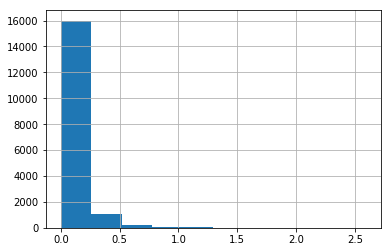

In [17]:
articles.popularity_score.hist();

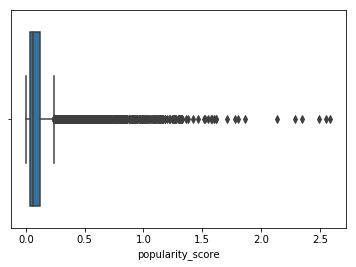

In [18]:
sns.boxplot(articles.popularity_score);

In [19]:
articles.loc[41927607]

title               Venezuelan protests (2014–present)
categories                              civil conflict
article_lenght                                0.300484
views                                      0.000843009
refs_count                                       0.315
link_count                                    0.281787
death                                                0
locations                                    Venezuela
end_date_clean                                       0
ongoing                                           True
popularity_score                              0.898114
Name: 41927607, dtype: object

In [20]:
articles.to_csv(DATA_DIR + 'articles_popularity_score.csv')

# 3. Data story

Translating that intuition into a number isn't easy. One thing we might try is looking at the number of references in a an article. References are used by the writer of the article to justify and cite the content present in the article. References are thus synonym of quality, in the context of a collaborative and openly enditable encyclopedia such as Wikipedia. 

We think that the references that are found at the bottom of the page of the articles could partially encapsulate the popularity of that article. So we analyze the references for each article. 

Plotting the `distribution of the number of references` and also in log-log scale, we notice that the distribution seems to follow a power law, which is somehow intuitive: a lot of pages do not have many many many many references. 

* 75 % of the articles have only 19 references. The maximum number of articles in a page reaches 1000 references!

This leads to another question!

**What kind of references are hidden among this data?** 

Let's have a look at the most commonly occurring references in the data. Also what is the trend?

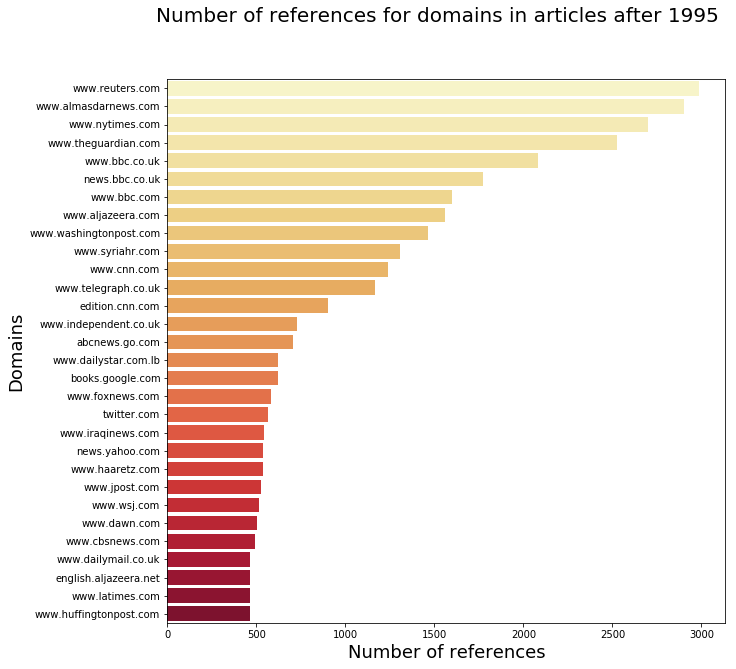

In [71]:
domains_distribution_pd30 = domains_distribution_pd.head(30)

# plot using bar plot
f, ax1 = plt.subplots()
plt.sca(ax1)
sns.barplot(domains_distribution_pd30['nb_ref'], domains_distribution_pd30.index, palette="YlOrRd", ax=ax1, orient='h')
plt.xlabel('Number of references',fontsize=18)
plt.ylabel('Domains',fontsize=18)
f.suptitle('Number of references for domains in articles after 1995', fontsize=20)
f.set_size_inches(10, 10)
plt.show()

For recent wikipedia conlfict-related articles (after 1995) most of the references come from the American, English and Arab media. American and English sources are no surprise as we are working with the English version of Wikipedia. In the top 5, [reuters](https://www.reuters.com) is the first! Interestingly, [almasdarnews](https://www.almasdarnews.com) is a close second. This online media source covers mostly conflicts in the Middle East: Syria, Yemen, and Iraq. 

That's one down, three more to go!

- [x] Number of references
- [ ] Number of views
- [ ] Article length
- [ ] Number of external links

# What about our other candidates?

Article length speaks for itself. The longer an article, the more likely it was edited and developed to fully cover the article topic. Looking at the number of views per page is also an important factor affecting the popularity of an article. Finally, the number of external links corresponds to the incoming links from other articles within Wikipedia.

Why not follow the trend? 

Exploring our other indicators of popularity 'article length', 'number of views', 'number of external links', let's see if these choices actually contribute to popularity of an article! 
To do so, we plot one indicator with respect to the other: we analyze if variables are either monotonic or independent, i.e. if article length increases, number of external links increases or does not vary. Imagine if 'article length' increases and at the same time 'number of views' decreases! Summing them up into popularity score would mean adding a negative coefficient otherwise the effect of one will partially cancel out the effect of the other one. 

,article_lenght,views,refs_count,link_count
article_lenght,1.000000,0.619499,0.715575,0.892395
views,0.619499,1.000000,0.477095,0.625089
refs_count,0.715575,0.477095,1.000000,0.582192
link_count,0.892395,0.625089,0.582192,1.000000


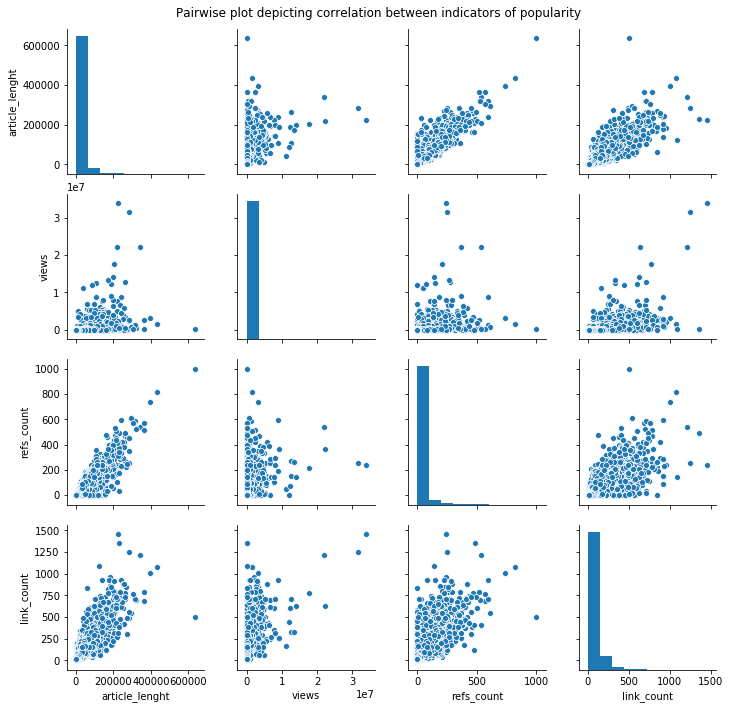

In [3]:
articles = pd.read_csv('../data/data_processed/data_processed.csv', index_col=0)
articles.index.names = ['id']
articles.head()
articles.end_date_clean = articles.end_date_clean.fillna(0)
ax = sns.pairplot(data=articles, vars=['article_lenght', 'views', 'refs_count', 'link_count']);
plt.subplots_adjust(top=0.95)
ax.fig.suptitle("Pairwise plot depicting correlation between indicators of popularity");
articles[['article_lenght', 'views', 'refs_count', 'link_count']].corr(method='spearman')

All variables seem more or less correlated, except 'views' that seem independent with respect to the others.
Also, the ranges are completely different! To be able to measure the influence of each component, they need to be comparable and thus on the same range to compute the popularity score. For this reason, we transform the features by scaling each feature to a range between 0 and 1 using [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).
We used this standardization approach instead of normalization to maintain the structure of the data, i.e. to preserve the distribution of the features.

- [x] Number of references
- [x] Number of views
- [x] Article length
- [x] Number of external links

# Popularity score

Having chosen our four features for quantifying the popularity of a page, and standardizing them to have them on the same range, we can compute the popularity score of an article.

For each article *x*, the popularity score is defined as:

 $score(x) = length(x) + views(x) + refs(x) + links(x)$

where 
* length is the scaled length of the article x
* views are the scaled number of views of the article x
* refs are the scaled number of references of the article x
* links are the scaled number of external links of the article x

# Survey

We want to double check that our score is correlated with what people think. We wrote a survey in order to verify that our metric is accurate.

We collected 2088 answers from more than 20 people. The user choices between left, right or 'Skip' in order to indicate the most popular conflict between the 2 proposed conflicts, i.e. it is a binary survey. 

The coverage of the survey is not incredible (12%) because we have more than 17 000 articles that can be used to write the survey, and some are really really unknown. Therefore, we randomly selected only articles that correspond to the middle to the top part of our popularity ranking.

We counted the number of correct answer for each popularity duel and we found out that 94 % of the answers to the questionaire match our popularity score, not bad! 

The metric thus seems to capture the popularity of the article. In this 6% of error, most of the errors seem to come more often from a missclick or a confusion rather than an error in our metric. For instance, two users thought that World War I is less popular than 2009 Jaipur fire or Battle of Adwa, which seems a bit unrealistic. Another group of errors arise from 2 unknown conflicts, like 2008 Bin Salman mosque bombing vs the Battle of Marawi. 
Having established that the metric seems realistic, we continue our investigation by looking at the findings our metric will give: spot important unpopular conflicts!

### Article popularity 

In [4]:
all_metrics_articles = pd.read_csv('../data/data_processed/NAS_articles_popularity_score.csv', index_col=0)

In [5]:
all_metrics_articles.sort_values(by='popularity_score', ascending=False).shape

(17467, 15)

In [6]:
all_metrics_articles['popularity_score'].describe().T

count    17467.000000
mean         0.106581
std          0.149411
min          0.001267
25%          0.033244
50%          0.059036
75%          0.117079
max          2.588225
Name: popularity_score, dtype: float64

In [7]:
pops = all_metrics_articles.sort_values(by='popularity_score', ascending=False).head()
middle_pop = pd.DataFrame(all_metrics_articles.loc[34975490]).T
no_pops = all_metrics_articles.sort_values(by='popularity_score', ascending=True).head()

In [8]:
best_worst_pops = pd.concat([no_pops, middle_pop, pops])
best_worst_pops

,title,categories,scaled_length,scaled_views,scaled_refs,scaled_links,death,locations,end_date_clean,ongoing,popularity_score,article_lenght,views,refs_count,link_count
49532277,Hashimiya attack,civilian attack,0.000558319,2.10427e-05,0,0.000687285,75,Hashimiya|Iraq,2014,False,0.00126665,881,753,0,2
58421339,Fifth Third Center shooting,civilian attack,0.000430928,4.31494e-05,0.001,0.000687285,0,NaN,0,False,0.00216136,800,1501,1,2
49429205,January 2015 Maiduguri suicide bombing,civilian attack,0.000470246,1.12011e-05,0.001,0.00206186,19,Maiduguri|Nigeria,0,False,0.0035433,825,420,1,4
50567259,Transkei War,military conflict,0.000786365,1.88557e-05,0,0.00274914,7000,South Africa Q258,1836,False,0.00355436,1026,679,0,5
56640476,Operation of Sidi Aïch,military conflict,0.00287023,4.87647e-06,0.001,0,0,Sidi Aïch|Tunisia,2015,False,0.00387511,2351,206,1,1
34975490,2012 Bucharest hair salon shooting,civilian attack,0.0174903,0.000127379,0.018,0.0233677,2,Bucharest Q19660,2012,False,0.0589854,11647,4351,18,35
32927,World War II,military conflict,0.350225,1,0.238,1,73000000,Russia Q159|Europe Q46|Africa Q15|Pacific ...,1945,False,2.58822,223212,33835972,238,1456
32611,Vietnam War,military conflict,0.534488,0.652728,0.536,0.832302,950765,South Vietnam Q180573,1975,False,2.55552,340373,22085710,536,1212
4764461,World War I,military conflict,0.4461,0.930421,0.254,0.860481,17000000,Europe Q46|Australia and Oceania Q55643|Mi...,1918,False,2.491,284173,31481685,254,1253
52019122,Battle of Mosul (2016–2017),military conflict,1,0.00491495,1,0.341581,9100,Erbil Governorate Q213189|Nineveh Governora...,2017,False,2.3465,636363,166343,1000,498


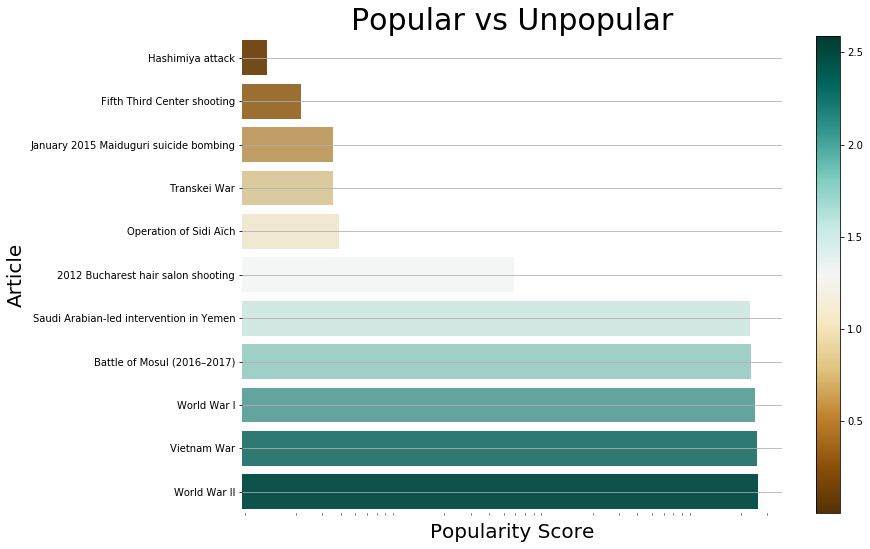

In [9]:
sort_best_worst_pops=best_worst_pops.sort_values(by='popularity_score')
f, axx = plt.subplots(figsize=(13, 8))
plot = plt.scatter(sort_best_worst_pops.title, sort_best_worst_pops.popularity_score, 
                   c=sort_best_worst_pops.popularity_score, 
                   cmap='BrBG')
plt.clf()
plt.colorbar(plot)
g = sns.barplot(
    x='popularity_score', y='title', data=sort_best_worst_pops, palette='BrBG')
g.set_xscale('log')
sns.despine(left=True, bottom=True)
g.axes.set_title("Popular vs Unpopular",fontsize=30)
g.set_xlabel("Popularity Score",fontsize=20)
g.set_ylabel("Article",fontsize=20)
sns.set(style="whitegrid")
plt.grid(axis='both')
plt.tight_layout()
plt.xticks([])
plt.show()

Not suprisingly, World War II is the most popular page! It has the highest popularity score of 2.59, with 
* article length: 223212	
* views: 33835972
* references: 238	
* external links: 1456

World War II being the most popular article hints that our metrics may be enough to encapsulate the popularity of a page. Because who hasn't studied World War II in school and looked up this article on Wikipedia?

# Is there a pattern between event date and popularity score?

We wonder if the attribution of the popularity score is partially influenced because of the event date and the importance of the article. By event date, we refer to the actual end date of the conflict the article is referring to (as our articles talk about conflicts). 
For now, the importance of an article is quantified by the number of deaths during that event.

Let's first have a quick look at the distribution of the article end dates.

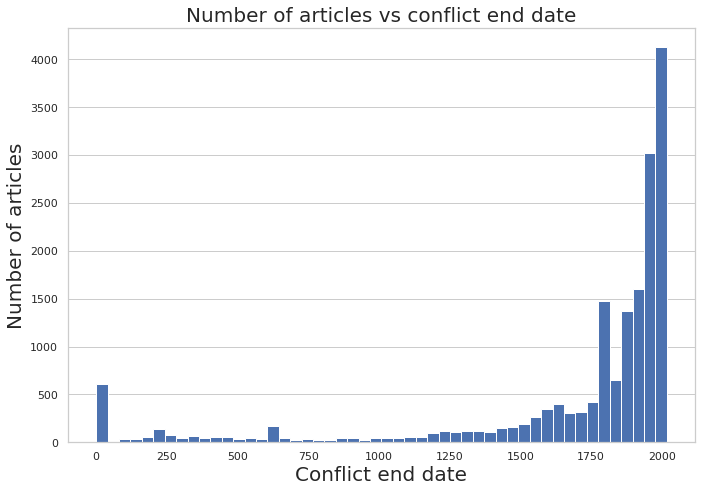

In [10]:
d = all_metrics_articles['end_date_clean'].hist(figsize=(10, 7), bins=50);
d.axes.set_title("Number of articles vs conflict end date",fontsize=20)
d.set_xlabel("Conflict end date",fontsize=20)
d.set_ylabel("Number of articles",fontsize=20)
plt.grid(axis='x')
plt.tight_layout()
plt.show()

The plot gives us a very broad range of conflict end dates. Since we are interested in more recent conflicts, 
as a first approach why don't we have a look at articles mentionning a conflict end date after 1910.

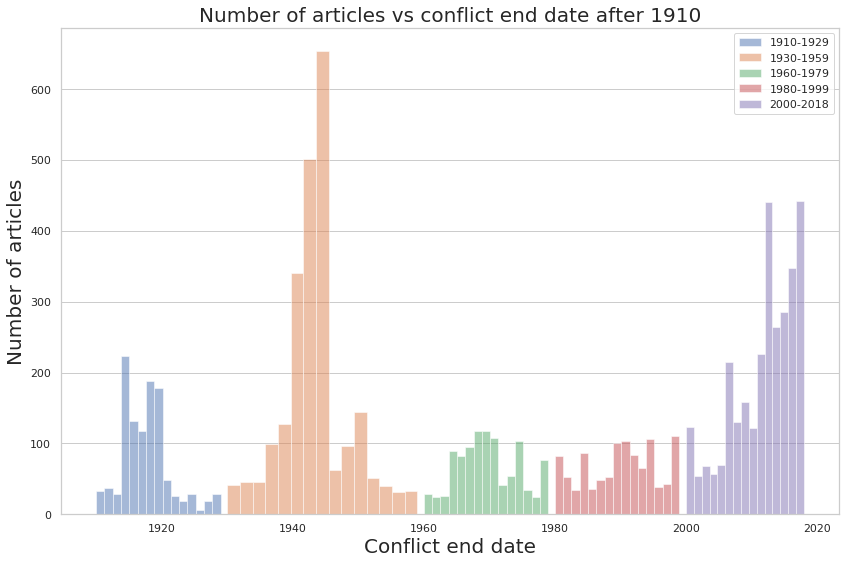

In [11]:
f = all_metrics_articles['end_date_clean'][(all_metrics_articles['end_date_clean'] >= 1910) &
                                           (all_metrics_articles['end_date_clean'] < 1930)
                                          ].hist(figsize=(12, 8), bins=15, alpha=0.5, label='1910-1929');
all_metrics_articles['end_date_clean'][(all_metrics_articles['end_date_clean'] >= 1930) &
                                           (all_metrics_articles['end_date_clean'] < 1960)
                                          ].hist(figsize=(12, 8), bins=15, alpha=0.5, label='1930-1959');
all_metrics_articles['end_date_clean'][(all_metrics_articles['end_date_clean'] >= 1960) &
                                           (all_metrics_articles['end_date_clean'] < 1980)
                                          ].hist(figsize=(12, 8), bins=15, alpha=0.5, label='1960-1979');
all_metrics_articles['end_date_clean'][(all_metrics_articles['end_date_clean'] >= 1980) &
                                           (all_metrics_articles['end_date_clean'] < 2000)
                                          ].hist(figsize=(12, 8), bins=15, alpha=0.5, label='1980-1999');
all_metrics_articles['end_date_clean'][(all_metrics_articles['end_date_clean'] >= 2000) &
                                           (all_metrics_articles['end_date_clean'] < 2019)
                                          ].hist(figsize=(12, 8), bins=15, alpha=0.5, label='2000-2018');

f.axes.set_title("Number of articles vs conflict end date after 1910",fontsize=20)
f.set_xlabel("Conflict end date",fontsize=20)
f.set_ylabel("Number of articles",fontsize=20)
plt.grid(axis='x')
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

Roughly five distinct population of articles are observed. The first peak around 1914 corresponds to World War I. Indeed, 1113 of our filtered articles have a end conflict end date between 1910-1930. The second peak around 1945 corresponds to World War 2, with more than 2300 articles belonging to that particular end conflict date. We can see that around an important conflict end date such as 1945, a lot of articles have talked about that conflict, making it even more significant in Wikipedia!

Since, we are more interesteted in recent events, let's fast-forward to 2017-2018. We are looking at article's describing ongoing conflicts.

In [268]:
all_metrics_articles[(all_metrics_articles['end_date_clean'] >= 2017) &
                                           (all_metrics_articles['end_date_clean'] < 2019)].shape

(442, 15)

In [12]:
# bar plot ongoing conclusion
data_2017_2018 = all_metrics_articles[all_metrics_articles['ongoing']==True]
data_2017_2018.shape

(32, 15)

# Ongoing conflicts 
Here, we look at the recent ongoing conflicts, and analyze the popularity of each article between 2017-2018.
Most popular articles deal with the Yemen and Syria conflicts.

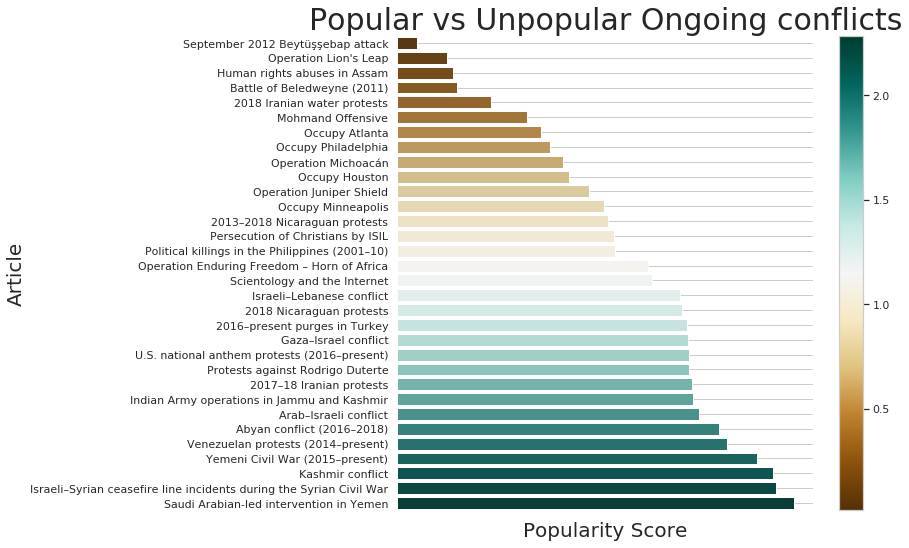

In [13]:
sort_data_2017_2018=data_2017_2018.sort_values(by='popularity_score')
f, axx = plt.subplots(figsize=(13, 8))
plot = plt.scatter(sort_data_2017_2018.title, sort_data_2017_2018.popularity_score, 
                   c=sort_data_2017_2018.popularity_score, 
                   cmap='BrBG')
plt.clf()
plt.colorbar(plot)
g = sns.barplot(
    x='popularity_score', y='title', data=sort_data_2017_2018, palette='BrBG')
g.set_xscale('log')
sns.despine(left=True, bottom=True)
g.axes.set_title("Popular vs Unpopular Ongoing conflicts",fontsize=30)
g.set_xlabel("Popularity Score",fontsize=20)
g.set_ylabel("Article",fontsize=20)
sns.set(style="whitegrid")
plt.grid(axis='both')
plt.tight_layout()
plt.xticks([])
plt.show()

Let's have a closer look at the unpopular articles. We want to understand if unpopular articles are unpopular because they are not "important" enough. Therefore, we decide to look at the number of deaths associated to each conflict.

In [14]:
sort_data_2017_2018[sort_data_2017_2018['death']>0]

,title,categories,scaled_length,scaled_views,scaled_refs,scaled_links,death,locations,end_date_clean,ongoing,popularity_score,article_lenght,views,refs_count,link_count
id,,,,,,,,,,,,,,,
36904359,September 2012 Beytüşşebap attack,military conflict,0.002578,0.000136,0.003,0.006873,21,Beytüşşebap Q853401,0.0,True,0.012587,2165,4654,3,11
18695217,Operation Michoacán,military conflict,0.022894,0.000811,0.023,0.048110,150,Michoacán Q79861,0.0,True,0.094815,15083,27471,23,71
28049183,Political killings in the Philippines (2001–10),civilian attack,0.043730,0.000787,0.029,0.118900,1200,Philippines Q928,0.0,True,0.192417,28331,26669,29,174
8812611,Operation Enduring Freedom – Horn of Africa,military conflict,0.091072,0.004951,0.094,0.116151,41,Horn of Africa Q40556,0.0,True,0.306174,58433,167555,94,170
6020082,Israeli–Lebanese conflict,military conflict,0.118738,0.009654,0.130,0.213058,17500,Israel Q801,0.0,True,0.471450,76024,326679,130,311
16346266,Gaza–Israel conflict,military conflict,0.138751,0.013458,0.165,0.213746,100,hlist Gaza Strip Southern District Israel ...,0.0,True,0.530955,88749,455401,165,312
56158430,2017–18 Iranian protests,civil conflict,0.175731,0.009483,0.176,0.195876,30,Iran Q794,0.0,True,0.557090,112262,320913,176,286
56082093,Indian Army operations in Jammu and Kashmir,military conflict,0.202303,0.000595,0.241,0.118900,2018,Jammu and Kashmir Q1180,0.0,True,0.562799,129158,20172,241,174
7960202,Arab–Israeli conflict,military conflict,0.152627,0.035753,0.137,0.284536,25343,Middle East Q7204,0.0,True,0.609917,97572,1209791,137,415


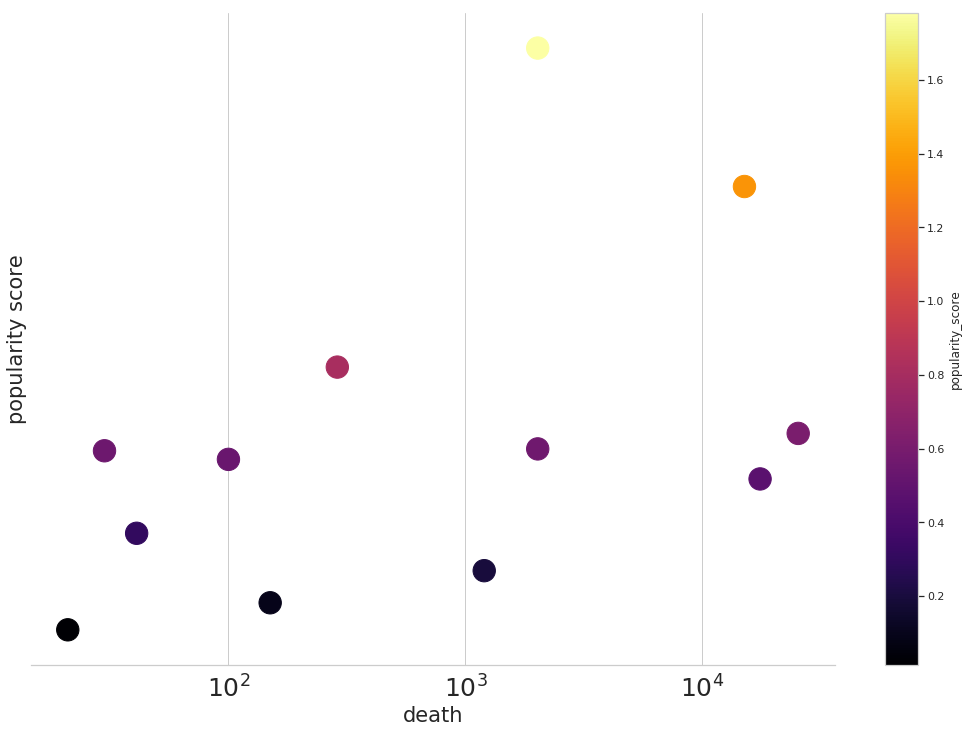

In [15]:
ax = sort_data_2017_2018[sort_data_2017_2018.death > 0].plot.scatter(x='death',
                        y='popularity_score',c='popularity_score',
                        figsize=(18,12),fontsize = 25,
                        colormap='inferno',sharex=False, s = 500)


ax.set_xlabel('death', fontsize=21)
ax.set_ylabel('popularity score', fontsize=21)
plt.xscale('symlog')
sns.despine(left=True, bottom=False)
plt.grid(axis='y')
plt.yticks([])
plt.show();

Interestingly, the number of death does not seem to correlate with the popularity of the article discussing ongoing conflicts: most of the ongoing conflicts have a low popularity score (< 0.6) but have a high number of death. Even with all articles (not only ongoing conflict) we can see that the number of death does not seem to correlate with the popularity of the article. All the articles follow the same trend!

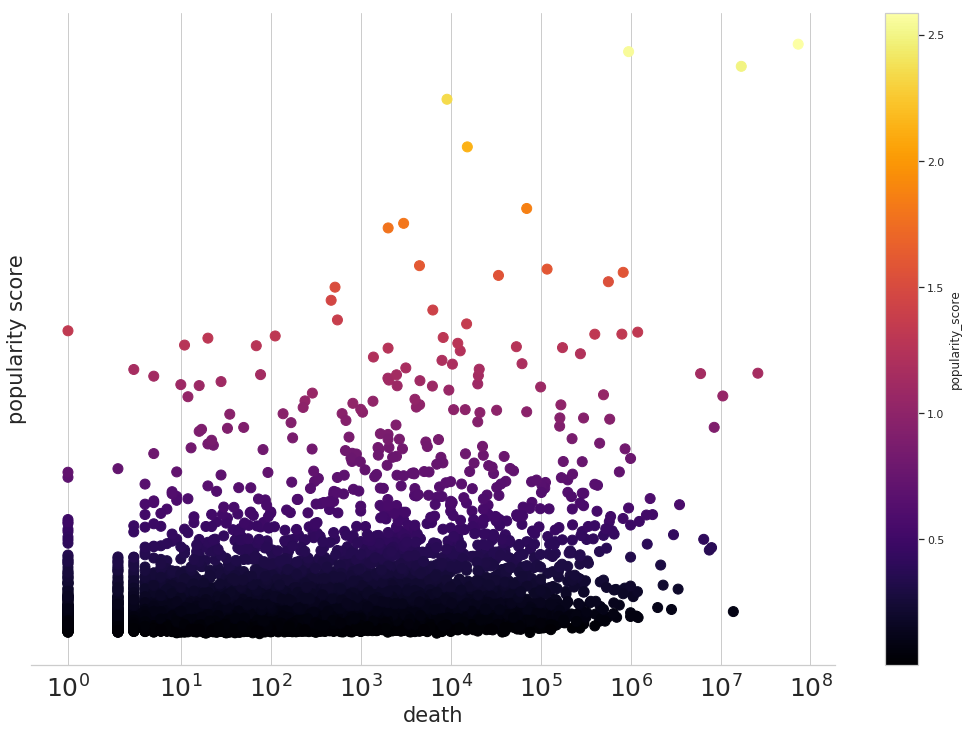

In [17]:
ax = all_metrics_articles[all_metrics_articles.death > 0].plot.scatter(x='death',
                        y='popularity_score',c='popularity_score',
                        figsize=(18,12),fontsize = 25,
                        colormap='inferno',sharex=False, s = 100)


ax.set_xlabel('death', fontsize=21)
ax.set_ylabel('popularity score', fontsize=21)
plt.xscale('symlog')
sns.despine(left=True, bottom=False)
plt.grid(axis='y')
plt.yticks([])
plt.show();

# Conclusion

Looking at articles in the recent years, we found that some unpopular articles may be not be completly unsignificant as these conflicts involve an considerable number of deaths. To live in a better world people must be aware of unpopular conflicts that have a high number of death! People will not have easily access to such articles because they are not cited very often, they do not appear in Google search, they even do not appear in the first pages of the wikipedia search. A way to overcome this barrier could be to monthly showcase these articles on the wikipedia front page. With this project we proposed an easy way (4 factors) of finding unpopular articles which could be improved in order to raise awardness on unknown conflicts involving victims.